$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Big Data Research

*Jason Stock*

In [1]:
import pandas as pd
import numpy as np 
import random
import time
from pprint import pprint
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib as mpl
import neuralnetworks as nn
import mlutils as ml
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
mpl.style.use('default')

### Functions
Same `trainNNs, summarize, bestNetwork, printBest` from PA5.

In [2]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures,
             numberRepetitions, numberIterations, classify = False):
    train_p, test_p, timing = [], [], []
    for network in hiddenLayerStructures:
        l_train_p, l_test_p = [], []
        sT = time.time()
        for rep in range(0, numberRepetitions):
            Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T,
                                                        (trainFraction, 1 - trainFraction),
                                                        classification = classify)
            if classify:
                nnet = nn.NeuralNetworkClassifier(Xtrain.shape[1],
                                                  network,
                                                  np.unique(T).shape[0])
                nnet.train(Xtrain, Ttrain, numberIterations)
                
                Ytrain = nnet.use(Xtrain)
                Ytest  = nnet.use(Xtest)
                
                l_train_p.append( np.sum(Ytrain!=Ttrain)/len(Ttrain) )
                l_test_p.append( np.sum(Ytest!=Ttest)/len(Ttest) )
            else:
                nnet = nn.NeuralNetwork(Xtrain.shape[1],
                                        network,
                                        Ttrain.shape[1])
                nnet.train(Xtrain, Ttrain, numberIterations)
    
                Ytrain = nnet.use(Xtrain)
                Ytest  = nnet.use(Xtest)
            
                l_train_p.append( np.mean( (Ytrain - Ttrain)**2) )
                l_test_p.append( np.mean( (Ytest  - Ttest )**2) )

        timing.append((time.time() - sT))
        
        train_p.append(l_train_p)
        
        test_p.append(l_test_p)
        
    return [ [hiddenLayerStructures[i], train_p[i], test_p[i], timing[i]]
                for i in range(0, len(hiddenLayerStructures)) ]

def summarize(results):
    for i in range(0, len(results)):
        results[i][1] = np.mean(results[i][1])
        results[i][2] = np.mean(results[i][2])
    
    return results

def bestNetwork(summary):
    min_index = np.argmin( [ [x[2]] for x in summary ] )
    return summary[min_index]

def printBest(best):
    print('\nBest:', best)
    print('\nHidden Layers {} Average Training {:.2f} Testing {:.2f} ' \
          'Took {:.4f} seconds'.format(*best))

### Data Analysis

I begin by looking at the input features to see how they are distributed and correlate to eachother.

Since the weather is consistent across all files (wc1.csv, wc2.csv, ..., wc3.csv) we can just look at one for correlations.

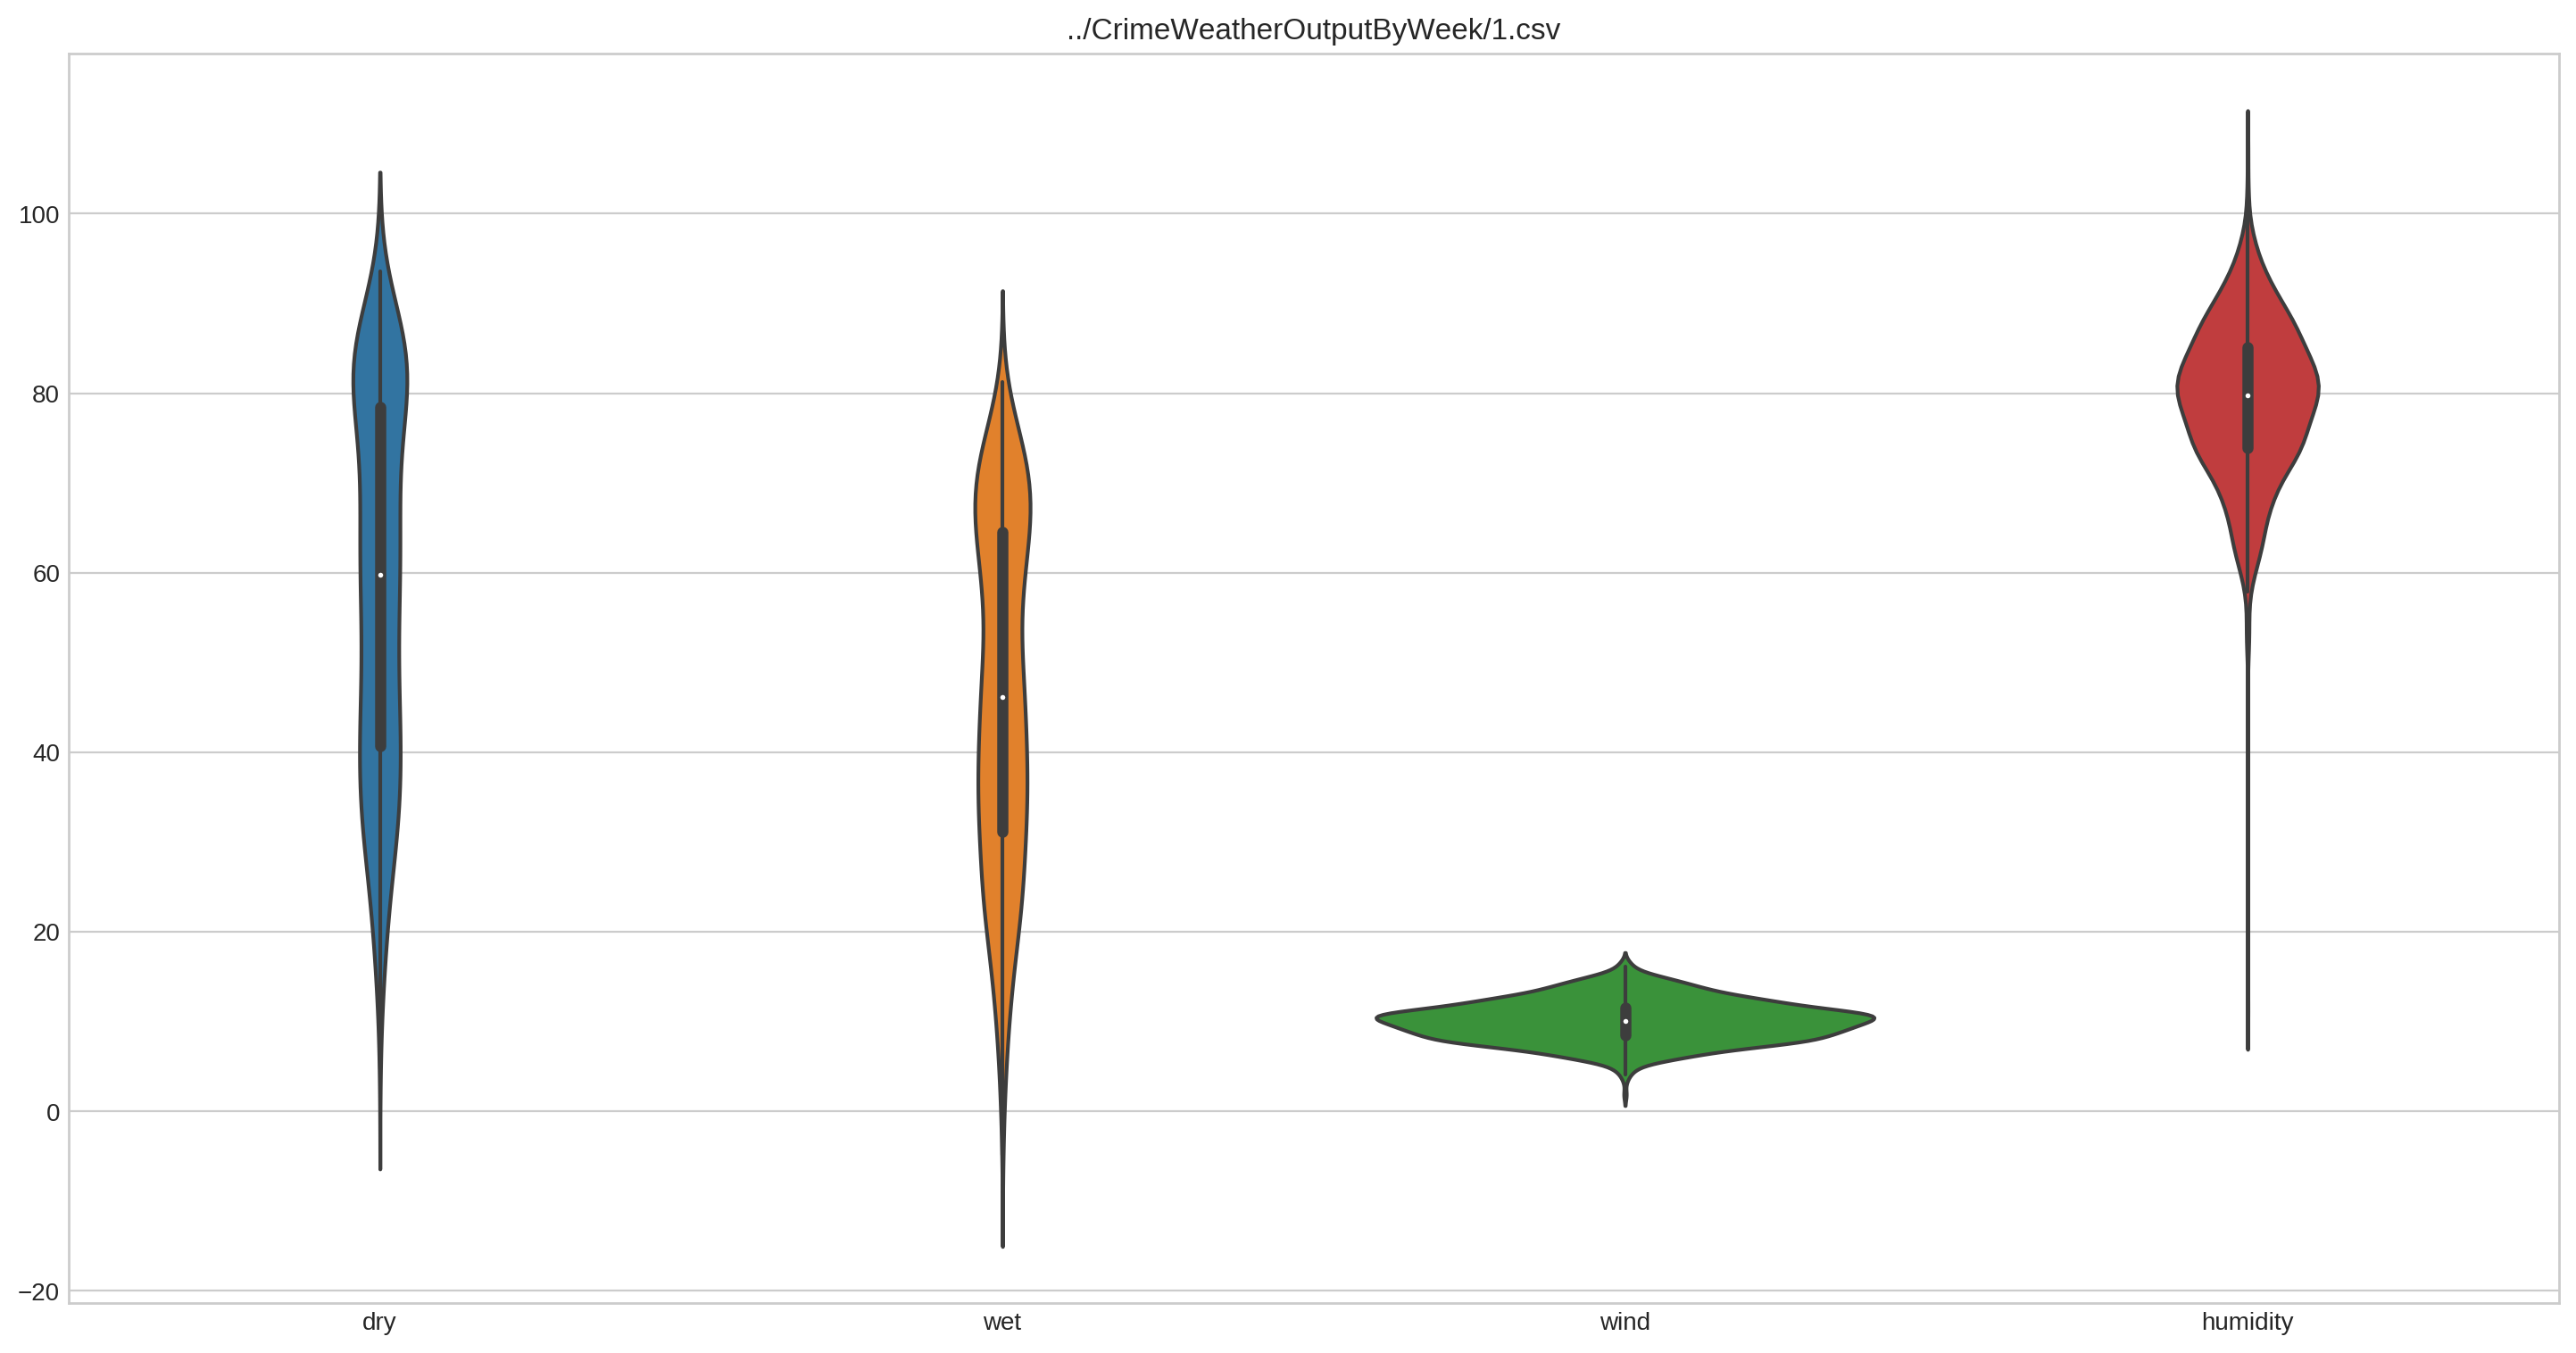

In [64]:
# #############################################################################
# Combination of boxplot and kernel density estimate for Wx data.
# May need to adjust figsize and subplot to fit more graphs.

def violin(num, columns, figheight, subplot_1, subplot_2):
    sns.set_style('whitegrid')
    plt.figure(figsize=(18,figheight))
    for i in range(num):
        plt.subplot(subplot_1,subplot_2,i+1)
        file = '../CrimeWeatherOutputByWeek/'+str(i+1)+'.csv'
        weather = pd.read_csv(file, sep=',', low_memory=False, 
                               names = ['date', 'dry', 'wet', 'wind',
                                        'humidity', 'district', 'homicide', 'robbery',
                                        'battery', 'assault', 'burglary', 'theft',
                                        'motor', 'weapons'], usecols = columns)
        plt.title(file)
        sns.violinplot(data=weather)

    plt.show()

NUM_PLOTS = 1
columns = range(1,5)
subplot_1 = 2
subplot_2 = 1
figheight = 20
violin(NUM_PLOTS, columns, figheight, subplot_1, subplot_2)

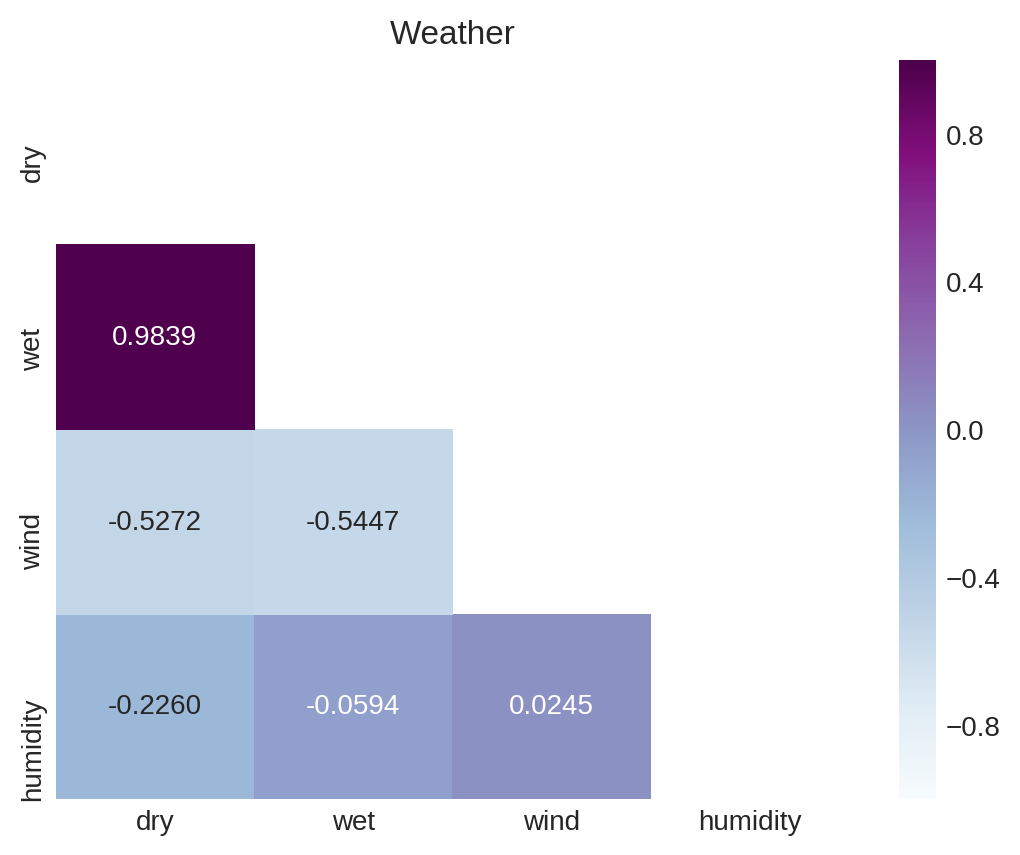

In [65]:
# #############################################################################
# Heatmap from the laster weather set of weather data read

district = '5'

file = '../CrimeWeatherOutputByWeek/'+district+'.csv'
weather = pd.read_csv(file, sep=',', low_memory=False, 
                       names = ['date', 'dry', 'wet', 'wind',
                                'humidity', 'district', 'homicide', 'robbery',
                                'battery', 'assault', 'burglary', 'theft',
                                'motor', 'weapons'], usecols = columns)

corr = weather.corr(method='pearson')
mask = np.zeros_like(corr,dtype=np.bool)

# set to False to view full matrix
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, fmt='.4f', mask=mask, cmap='BuPu', robust=True)
plt.title('Weather')

plt.show()

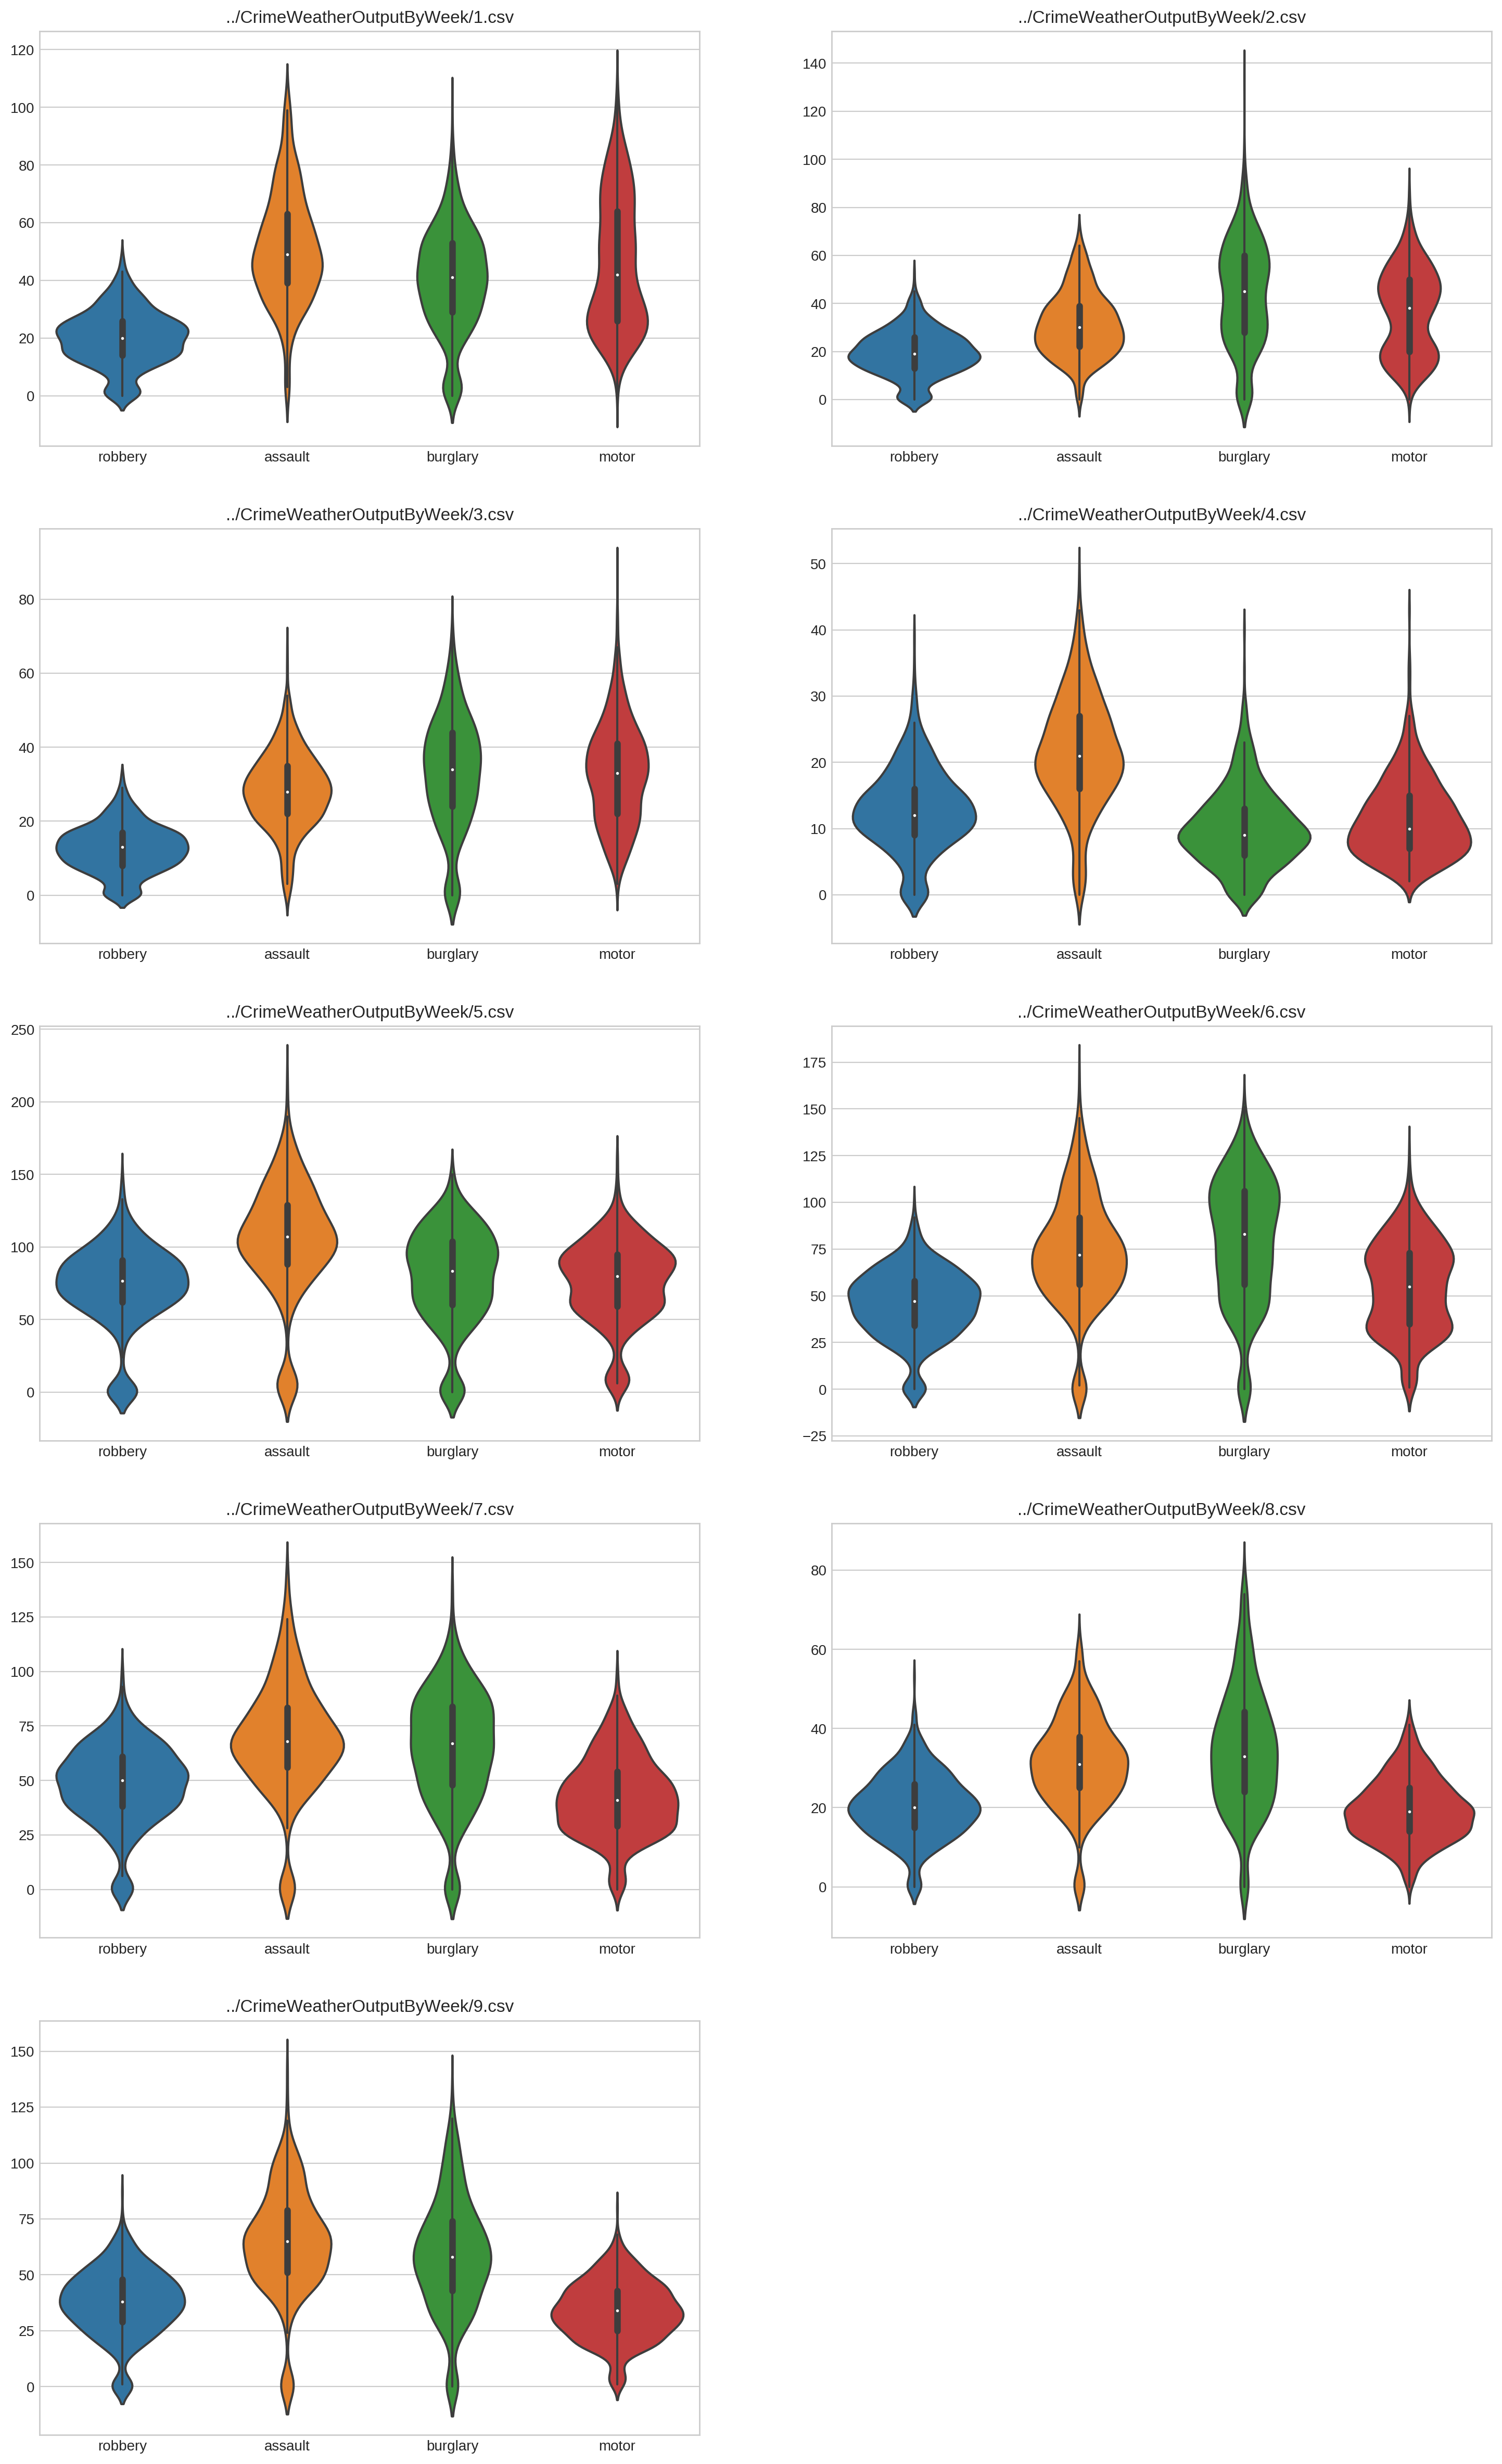

In [66]:
# #############################################################################
# Look at output features (crime) over districts

NUM_PLOTS = 9
columns = [7, 9, 10, 12]
subplot_1 = 5
subplot_2 = 2
figheight = 30
violin(NUM_PLOTS, columns, figheight, subplot_1, subplot_2)

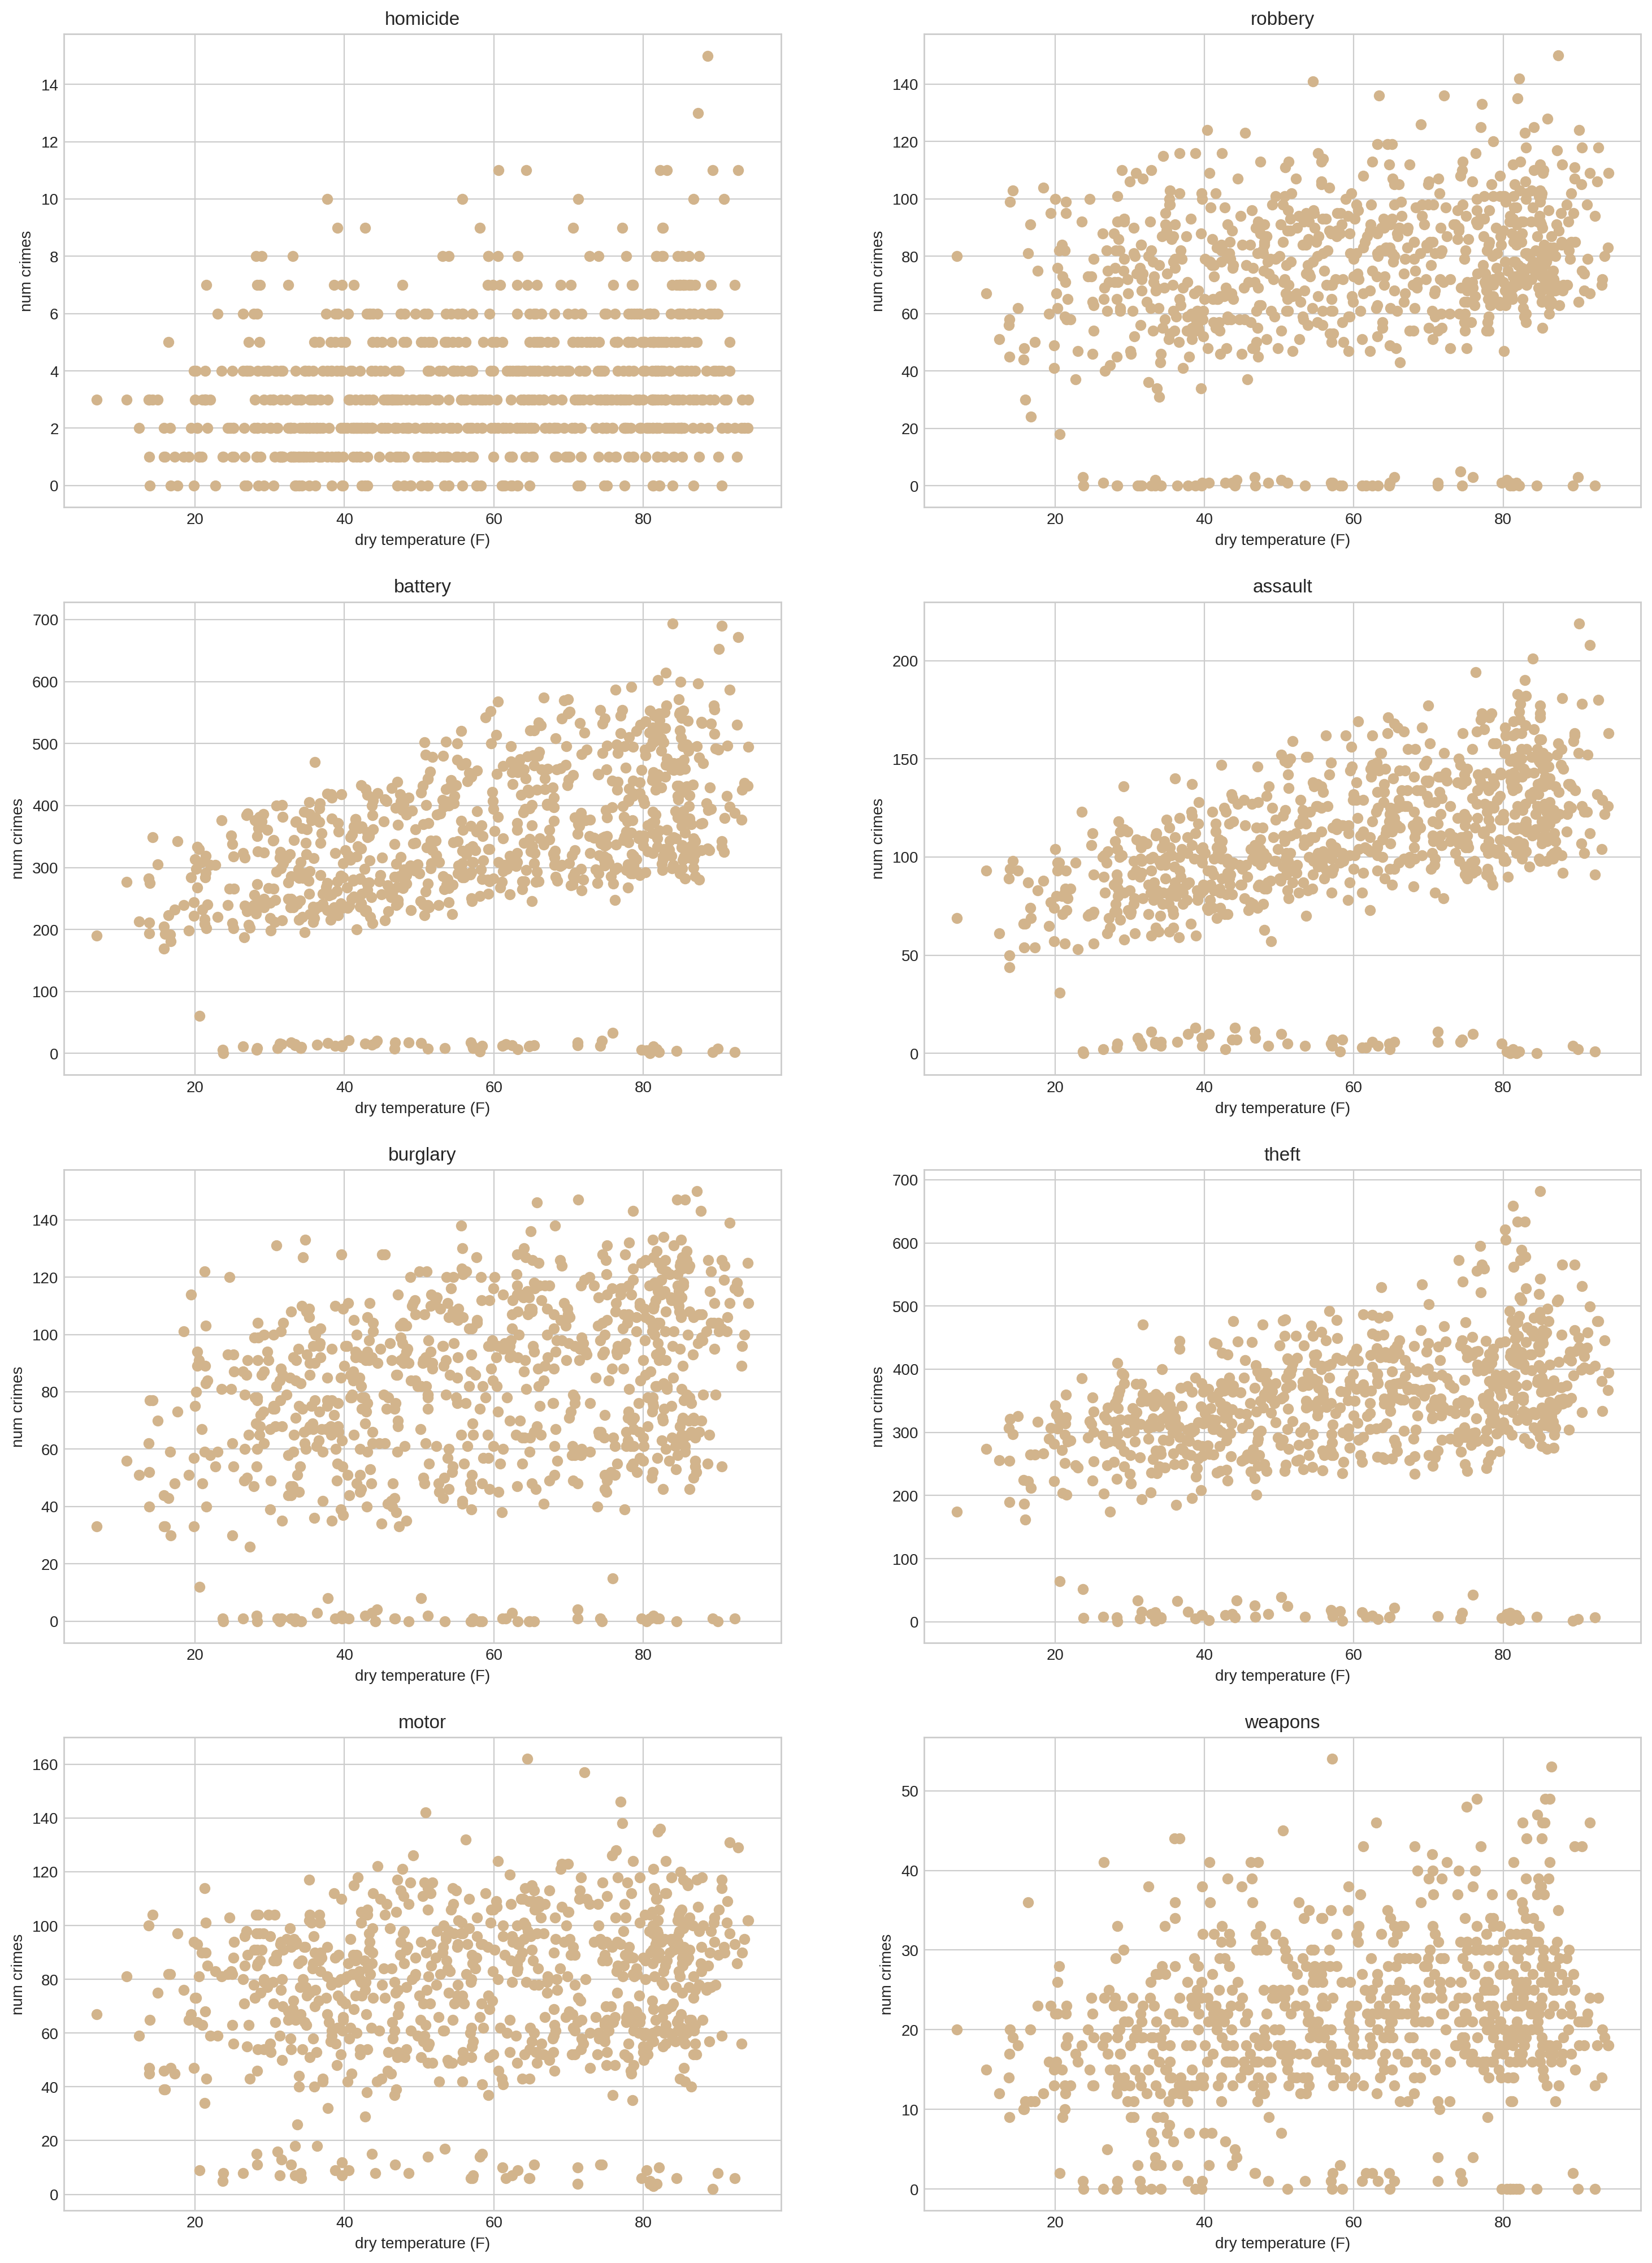

In [67]:
# #############################################################################
# Number of crimes versus dry bulb temperature

def scatter_crime(data):
    col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']
    xAxis = 'dry'
    plt.figure(figsize=(18,25))
    for i in range(len(col)):
        plt.subplot(4,2,i+1)  
        plt.scatter(data[xAxis], data[col[i]], color='tan')
        plt.title(col[i])
        plt.xlabel(xAxis + ' temperature (F)'), plt.ylabel('num crimes')
        
    plt.show() 

data = pd.read_csv('../CrimeWeatherOutputByWeek/5.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

data.sort_values(by=['date'], inplace=True)
#data.head()
scatter_crime(data)

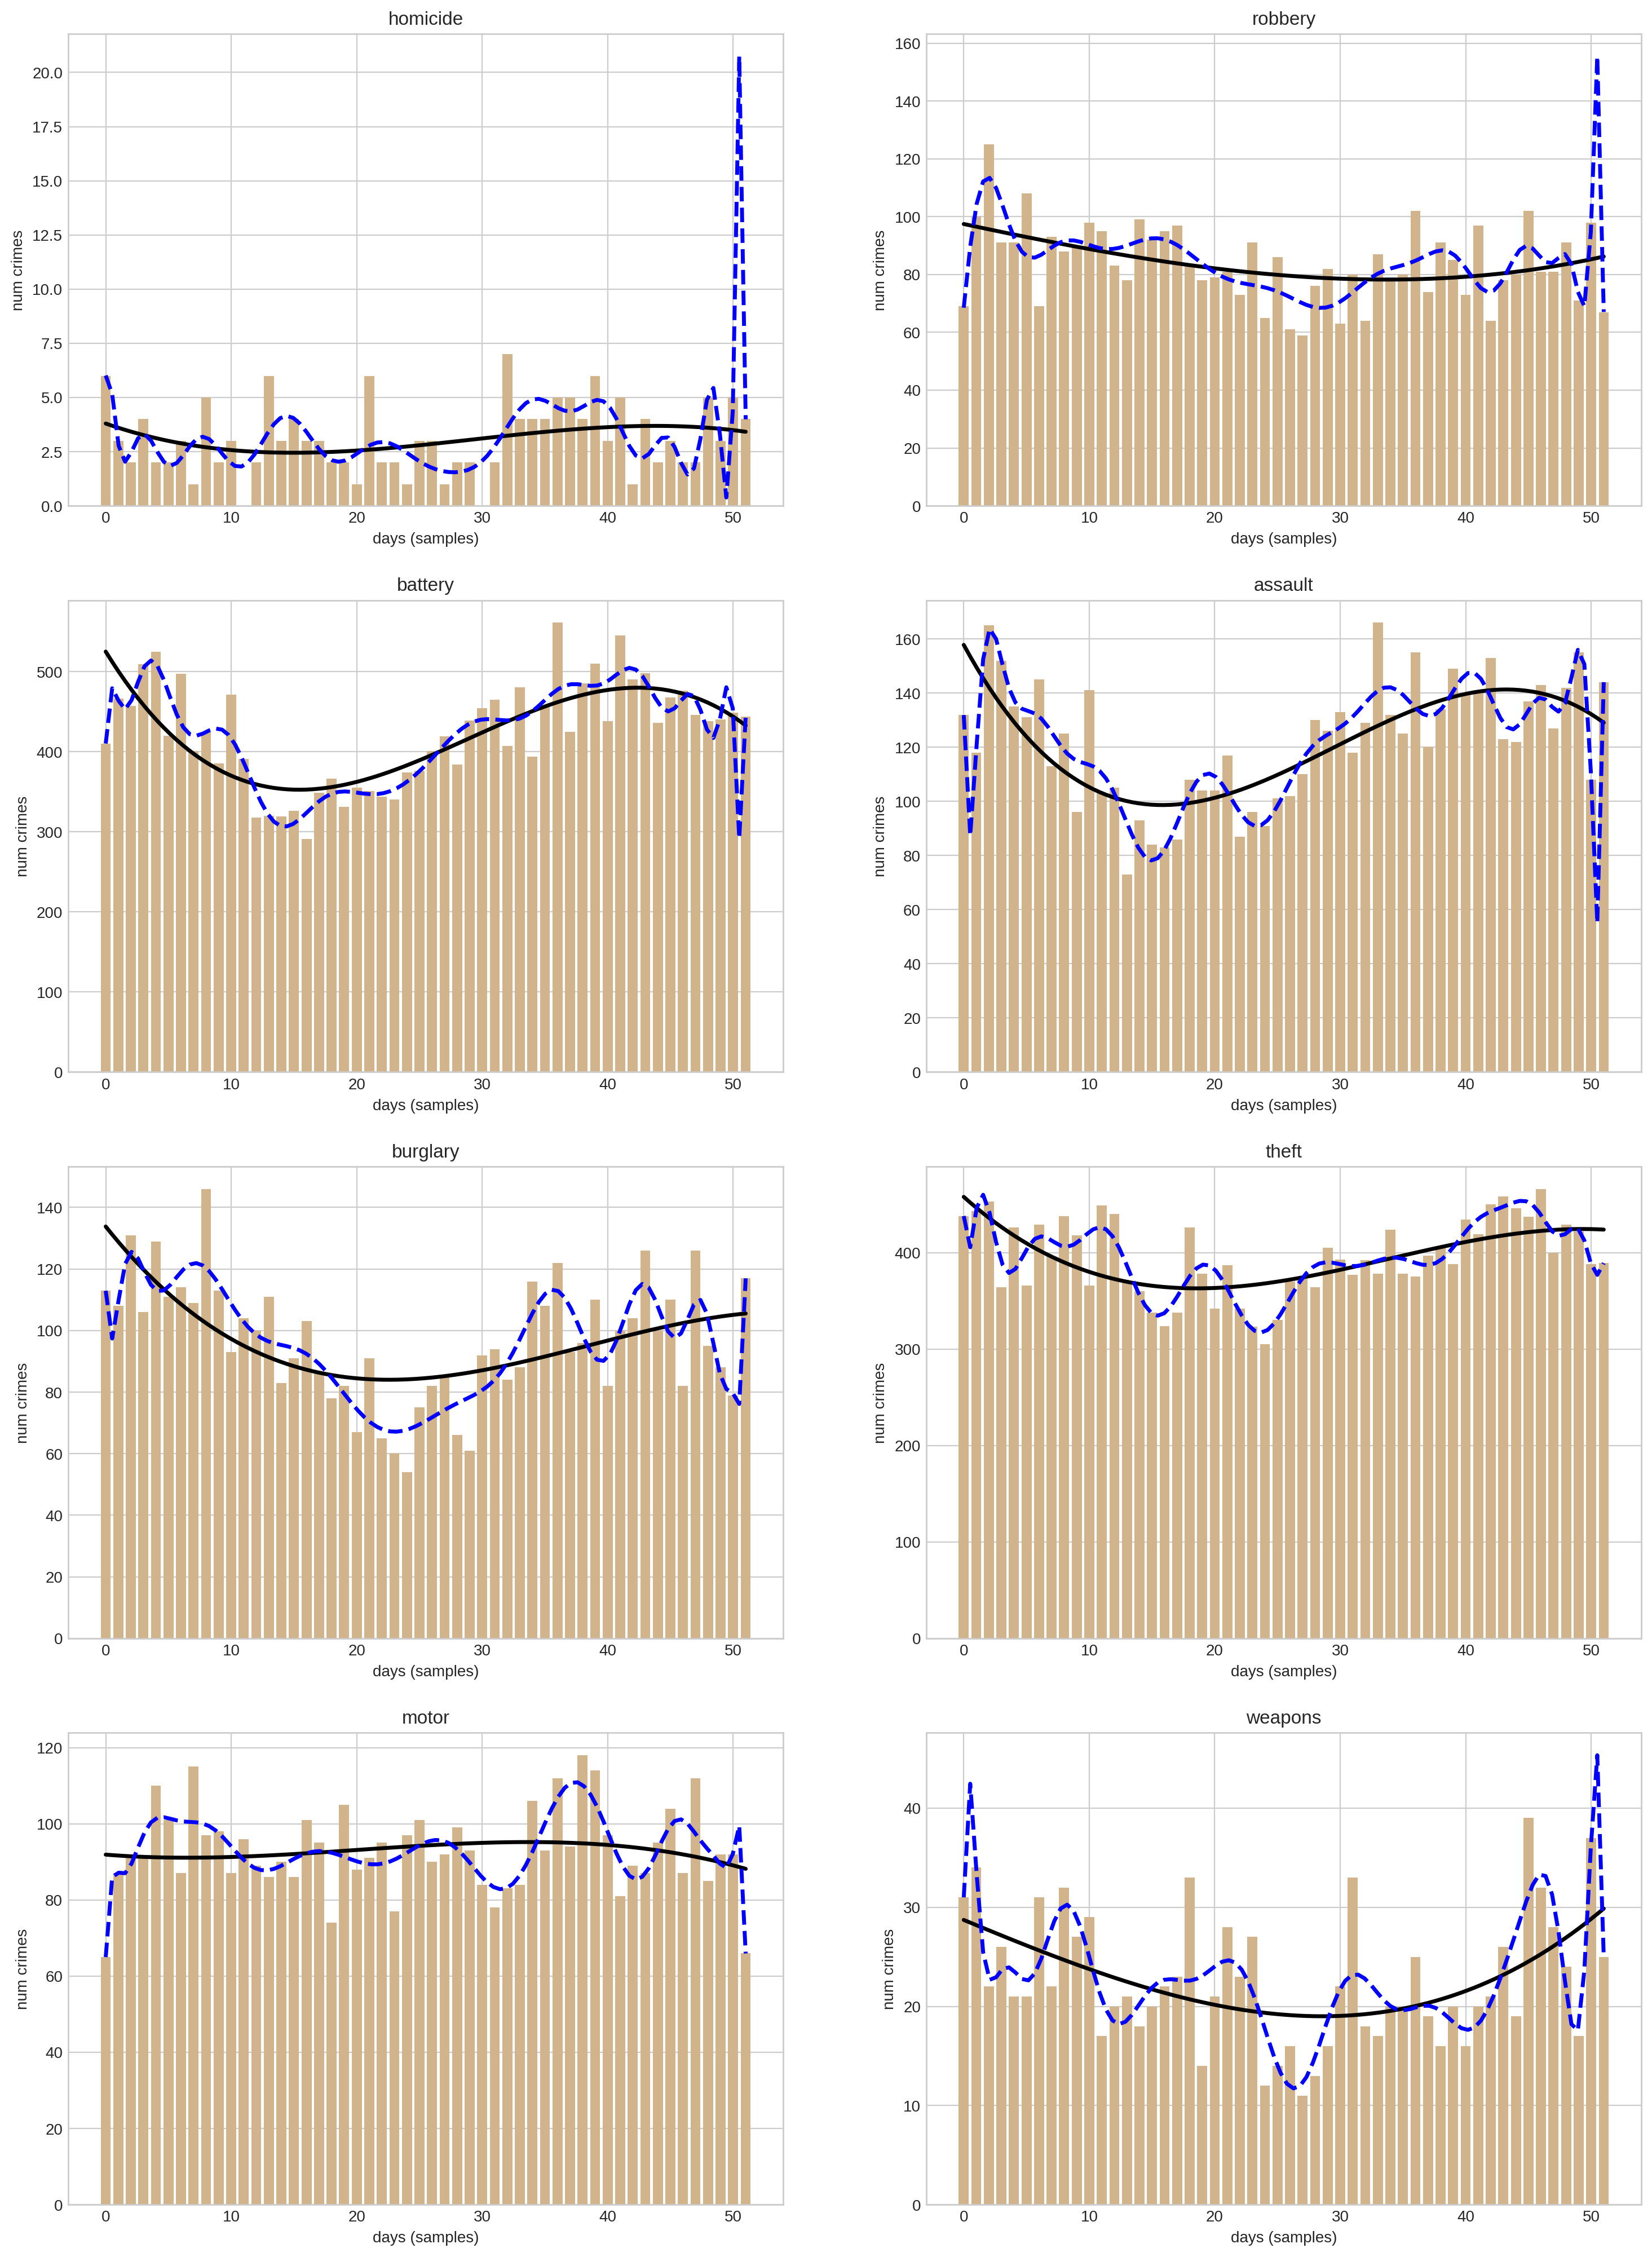

In [68]:
# #############################################################################
# Crimes over time by yearly subsets

def bar_crime(data, year):
    col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']
    plt.figure(figsize=(18,25))
    
    for i in range(len(col)):
        plt.subplot(4,2,i+1)  
        y = data[col[i]][52*(year - 1):52*year]
        x = np.arange(len(y))
        z = np.polyfit(x, y, 3)
        
        p = np.poly1d(z)
        p30 = np.poly1d(np.polyfit(x, y, 30))
        xp = np.linspace(0, len(y) - 1, 100)
        
        plt.bar(x, y, color='tan')
        _ = plt.plot(xp, p(xp), 'k-', xp, p30(xp), 'b--', lw=2.5)
        plt.title(col[i])
        plt.xlabel('days (samples)'), plt.ylabel('num crimes') 
        
    plt.show() 

# Adjust year and district, 1-17 and 1-9 respectively

year = 5
district = '5'

data = pd.read_csv('../CrimeWeatherOutputByWeek/'+district+'.csv', sep=',', low_memory=False, 
               names = ['date', 'dry', 'wet', 'wind',
                        'humidity', 'district', 'homicide', 'robbery',
                        'battery', 'assault', 'burglary', 'theft',
                        'motor', 'weapons'])
data.sort_values(by=['date'], inplace=True)
#data.head()
bar_crime(data, year)

In [59]:
# #############################################################################
# Read in data for rest of experiments

district = '5'

data = pd.read_csv('../CrimeWeatherOutputByWeek/'+district+'.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

In [60]:
# #############################################################################
# Sample the data

data.head()

date        dry        wet       wind   humidity  district  homicide  \
0     1  23.787971  18.099911  10.572667  79.141978         5         1   
1    10  44.100283  32.066904  11.013401  79.474713         5         4   
2   100  55.647168  38.879705  11.712001  68.877434         5         3   
3   101  47.059061  35.068150  12.424910  79.672353         5         2   
4   102  51.195301  32.953753  11.417448  67.908725         5         6   

   robbery  battery  assault  burglary  theft  motor  weapons  
0        0        0        0         0      6      8        0  
1        0       17       13         0      7      8        5  
2      106      520      136        65    400     97       27  
3       81      438      146        86    396    117       16  
4       96      444      142        74    415    114       25

In [61]:
# #############################################################################
# Check for NaN / Missing values and dtype

data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 14 columns):
date        810 non-null int64
dry         810 non-null float64
wet         810 non-null float64
wind        810 non-null float64
humidity    810 non-null float64
district    810 non-null int64
homicide    810 non-null int64
robbery     810 non-null int64
battery     810 non-null int64
assault     810 non-null int64
burglary    810 non-null int64
theft       810 non-null int64
motor       810 non-null int64
weapons     810 non-null int64
dtypes: float64(4), int64(10)
memory usage: 88.7 KB


In [62]:
# #############################################################################
# Descriptive statistics that summarize the central tendency, 
# dispersion and shape of the entire data distribution

data.describe()

date         dry         wet        wind    humidity  district  \
count  810.000000  810.000000  810.000000  810.000000  810.000000     810.0   
mean   405.500000   58.550718   46.259293   10.077983   79.280052       5.0   
std    233.971152   21.149412   19.506954    2.301529    8.636883       0.0   
min      1.000000    6.809010   -2.787603    3.246611   21.415860       5.0   
25%    203.250000   40.858653   31.173593    8.353946   73.668577       5.0   
50%    405.500000   59.819923   46.146943   10.050627   79.803680       5.0   
75%    607.750000   78.379656   64.528969   11.599435   84.985812       5.0   
max    810.000000   94.080836   81.855008   17.355810  105.996938       5.0   

         homicide     robbery     battery     assault    burglary       theft  \
count  810.000000  810.000000  810.000000  810.000000  810.000000  810.000000   
mean     3.402469   73.516049  335.954321  104.992593   79.456790  330.532099   
std      2.261844   27.474143  129.970669   38.629263   32.955545  116.258714   
min      0.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
25%      2.000000   62.000000  275.000000   88.000000   60.000000  288.000000   
50%      3.000000   76.500000  335.000000  107.000000   83.500000  341.500000   
75%      5.000000   91.000000  419.750000  129.000000  104.000000  397.750000   
max     15.000000  150.000000  694.000000  219.000000  150.000000  682.000000   

            motor     weapons  
count  810.000000  810.000000  
mean    76.128395   21.123457  
std     27.732624    9.711007  
min      2.000000    0.000000  
25%     59.250000   16.000000  
50%     80.000000   21.000000  
75%     95.000000   27.000000  
max    162.000000   54.000000

### Neural Network

Using SGD from Dr. Anderson by use of the NN package.

In [25]:
# #############################################################################
# Normalize the data

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [26]:
# #############################################################################
# Read in X and T by items in a list, e.g., [2, 3, 5], range(5), etc.

def sampler(data, a, b):
    
    X = data.iloc[:, np.r_[a]]
    T = data.iloc[:, np.r_[b]]
        
    return np.array(X), np.array(T)

X, T = sampler(data, [1,2], range(6,14)) # 6,14

In [27]:
X[:5], T[:5]

(array([[0.1945526 , 0.24677304],
        [0.42730024, 0.41178441],
        [0.55960967, 0.49227342],
        [0.46120326, 0.44724227],
        [0.50859816, 0.42226197]]),
 array([[  1,   0,   0,   0,   0,   6,   8,   0],
        [  4,   0,  17,  13,   0,   7,   8,   5],
        [  3, 106, 520, 136,  65, 400,  97,  27],
        [  2,  81, 438, 146,  86, 396, 117,  16],
        [  6,  96, 444, 142,  74, 415, 114,  25]]))

In [15]:
# #############################################################################
# Return predicted values from training and running

def get_values(X, T, network, train_f, itr, partition = False):
    if partition: 
        Xtrain, Ttrain, Xtest, T = ml.partition(X, T, (train_f, 1 - train_f))
        
        nnet = nn.NeuralNetwork(Xtrain.shape[1], network, Ttrain.shape[1])
        nnet.train(Xtrain, Ttrain, itr)
        Y = nnet.use(Xtest)
        
    else:  
        nnet = nn.NeuralNetwork(X.shape[1], network, T.shape[1]) 
        nnet.train(X, T, itr)
        Y = nnet.use(X)
        
    return Y, T, nnet.getErrorTrace()

Network 1: [59, 59, 59] with 1200 iterations.
Network 2: [67, 67, 67] with 1260 iterations.
Network 3: [69, 69, 69, 69, 69] with 1323 iterations.
Network 4: [36, 36, 36, 36, 36] with 1389 iterations.
Network 5: [57, 57, 57, 57, 57] with 1458 iterations.
Network 6: [68, 68, 68] with 1530 iterations.
Network 7: [50, 50, 50, 50, 50] with 1606 iterations.
Network 8: [37, 37, 37, 37, 37] with 1686 iterations.
Network 9: [66, 66, 66, 66, 66] with 1770 iterations.
Network 10: [58, 58, 58] with 1858 iterations.
Network 11: [47, 47, 47] with 1950 iterations.
Network 12: [47, 47, 47, 47] with 2047 iterations.
Network 13: [64, 64, 64, 64] with 2149 iterations.
Network 14: [59, 59, 59] with 2256 iterations.
Network 15: [69, 69, 69, 69] with 2368 iterations.
Network 16: [72, 72, 72, 72, 72] with 2486 iterations.
Network 17: [47, 47, 47, 47] with 2610 iterations.
Network 18: [67, 67, 67] with 2740 iterations.
Network 19: [50, 50, 50, 50, 50] with 2877 iterations.
Network 20: [42, 42, 42, 42, 42] wit

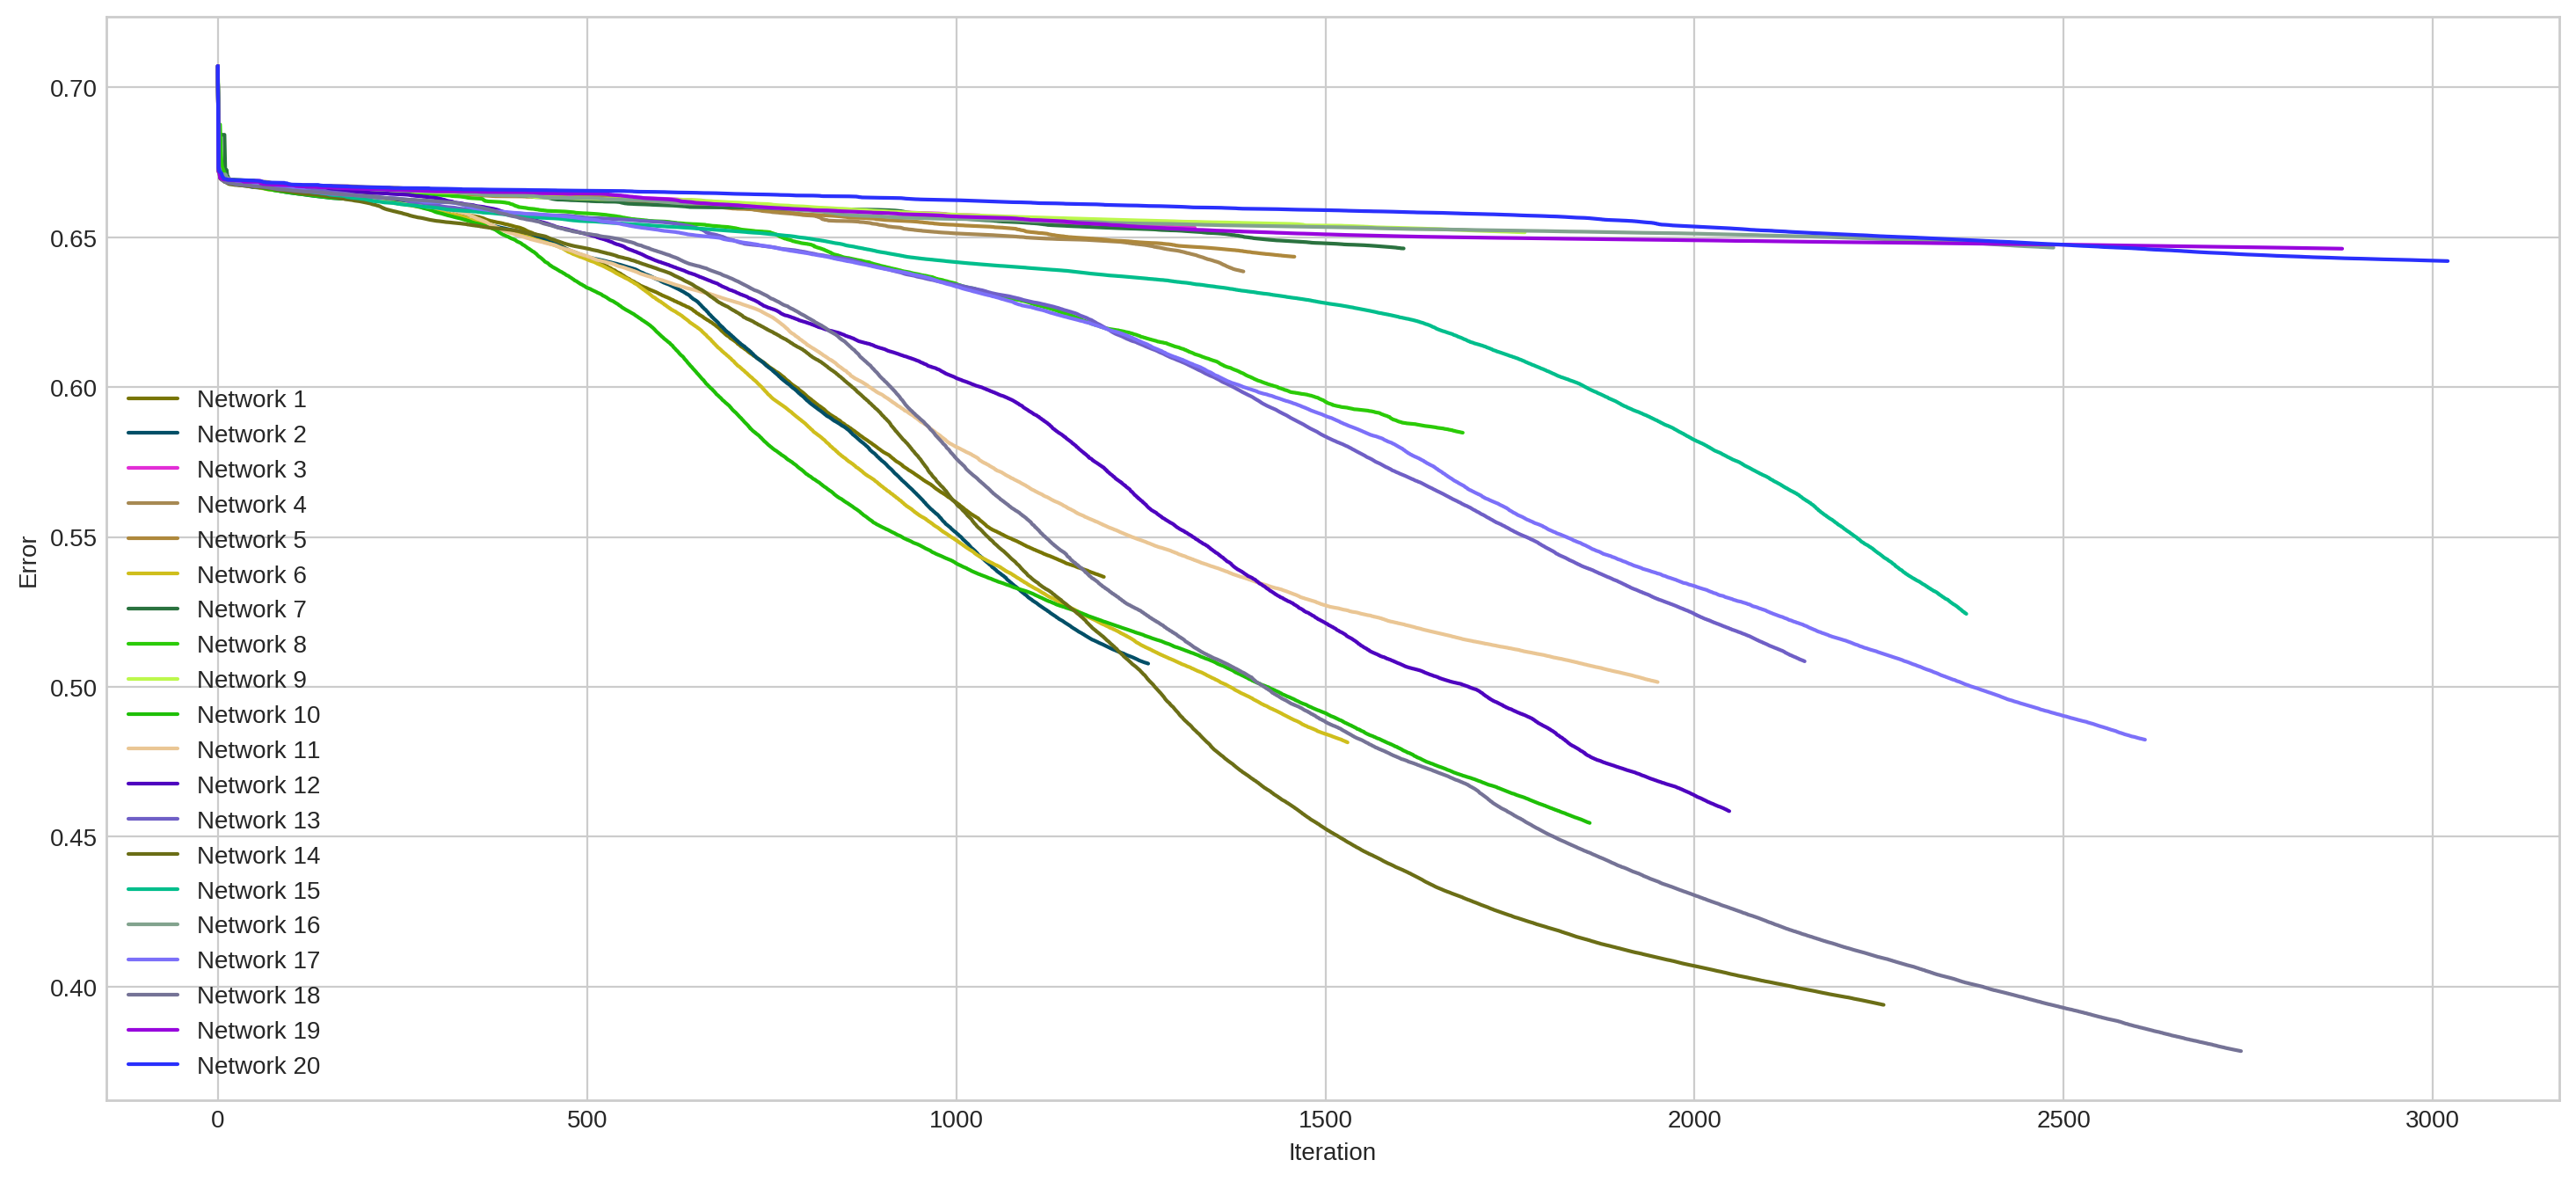

In [16]:
# #############################################################################
# Look at Error / Network / Iterations

sns.set_style("whitegrid")

numberItr = 1200
train_f = 0.8
er = []

for i in range(20):
    a = np.random.randint(35, 75)
    b = np.random.randint(3, 6)
    print('Network', str(i+1) + ':', [a]*b,
          'with', numberItr, 'iterations.')

    Y, _T, error = get_values(X, T, [a]*b, train_f, numberItr)
    er.append(error)
    numberItr = int(1.05 * numberItr)

plt.figure(figsize=(18,8))
for i, pl in enumerate(er):
    plt.plot(pl, c=np.random.rand(3,), label = 'Network '+str(i+1))

plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

In [17]:
# #############################################################################
# Deeper network.  Found no difference when running.

'''
numberItr = 500
er = []

for i in range(14):
    a = np.random.randint(1, 50)
    b = np.random.randint(5, 20)
    print('Network', str(i+1) + ':', [a]*b,
          'with', numberItr, 'iterations.')

    Y, _T, error = get_values(X, T, [a]*b, train_f, numberItr)
    er.append(error)
    numberItr = int(1.15 * numberItr)

plt.figure(figsize=(18,6))
for i, pl in enumerate(er):
    plt.plot(pl, label = 'Network '+str(i+1))

plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()
'''
print('check')

check


In [54]:
# #############################################################################
# Retrieve the best NN structure.  
# Best seen [67, 67, 67, 67] 2000 80/20 District 4
# MIN ERROR 0.49223388006888474, RMSE: 33.93454955140849
# [72, 72, 72, 72]
# ERROR MIN: 0.46960927770591065, RMSE: 35.984220552712344

itr = 300
hidden = []
trainFraction = 0.80
numberRepetitions = 10

for i in range(8):
    a = np.random.randint(0, 75)
    b = np.random.randint(3, 6)
    hidden.append([a]*b)

results = trainNNs(X, T, trainFraction, hidden,
                   numberRepetitions, itr)
summary = summarize(results)
best    = bestNetwork(summary)

pprint(summary)
printBest(best)

[[[58, 58, 58, 58, 58],
  3598.2362584696357,
  3541.5453387343796,
  20.813223600387573],
 [[37, 37, 37, 37, 37],
  3563.025147969468,
  3650.4456455268723,
  14.416284799575806],
 [[0, 0, 0], 4275.592078308377, 4507.953839806241, 0.008775711059570312],
 [[12, 12, 12, 12, 12],
  3615.0490816529114,
  3486.871950270307,
  9.463981628417969],
 [[40, 40, 40], 3511.0384051105552, 3651.805633141868, 9.165599822998047],
 [[27, 27, 27], 3432.7814617236063, 3825.81705359868, 6.939042091369629],
 [[16, 16, 16, 16], 3527.3958297871795, 3687.053905977084, 6.0775275230407715],
 [[57, 57, 57], 3386.019213604799, 4059.9039673025136, 13.227125883102417]]

Best: [[12, 12, 12, 12, 12], 3615.0490816529114, 3486.871950270307, 9.463981628417969]

Hidden Layers [12, 12, 12, 12, 12] Average Training 3615.05 Testing 3486.87 Took 9.4640 seconds


Network: [12, 12, 12, 12, 12]
ERROR MIN: 0.6569053801087492 for 300 iterations
RMSE: 4500.74125330817


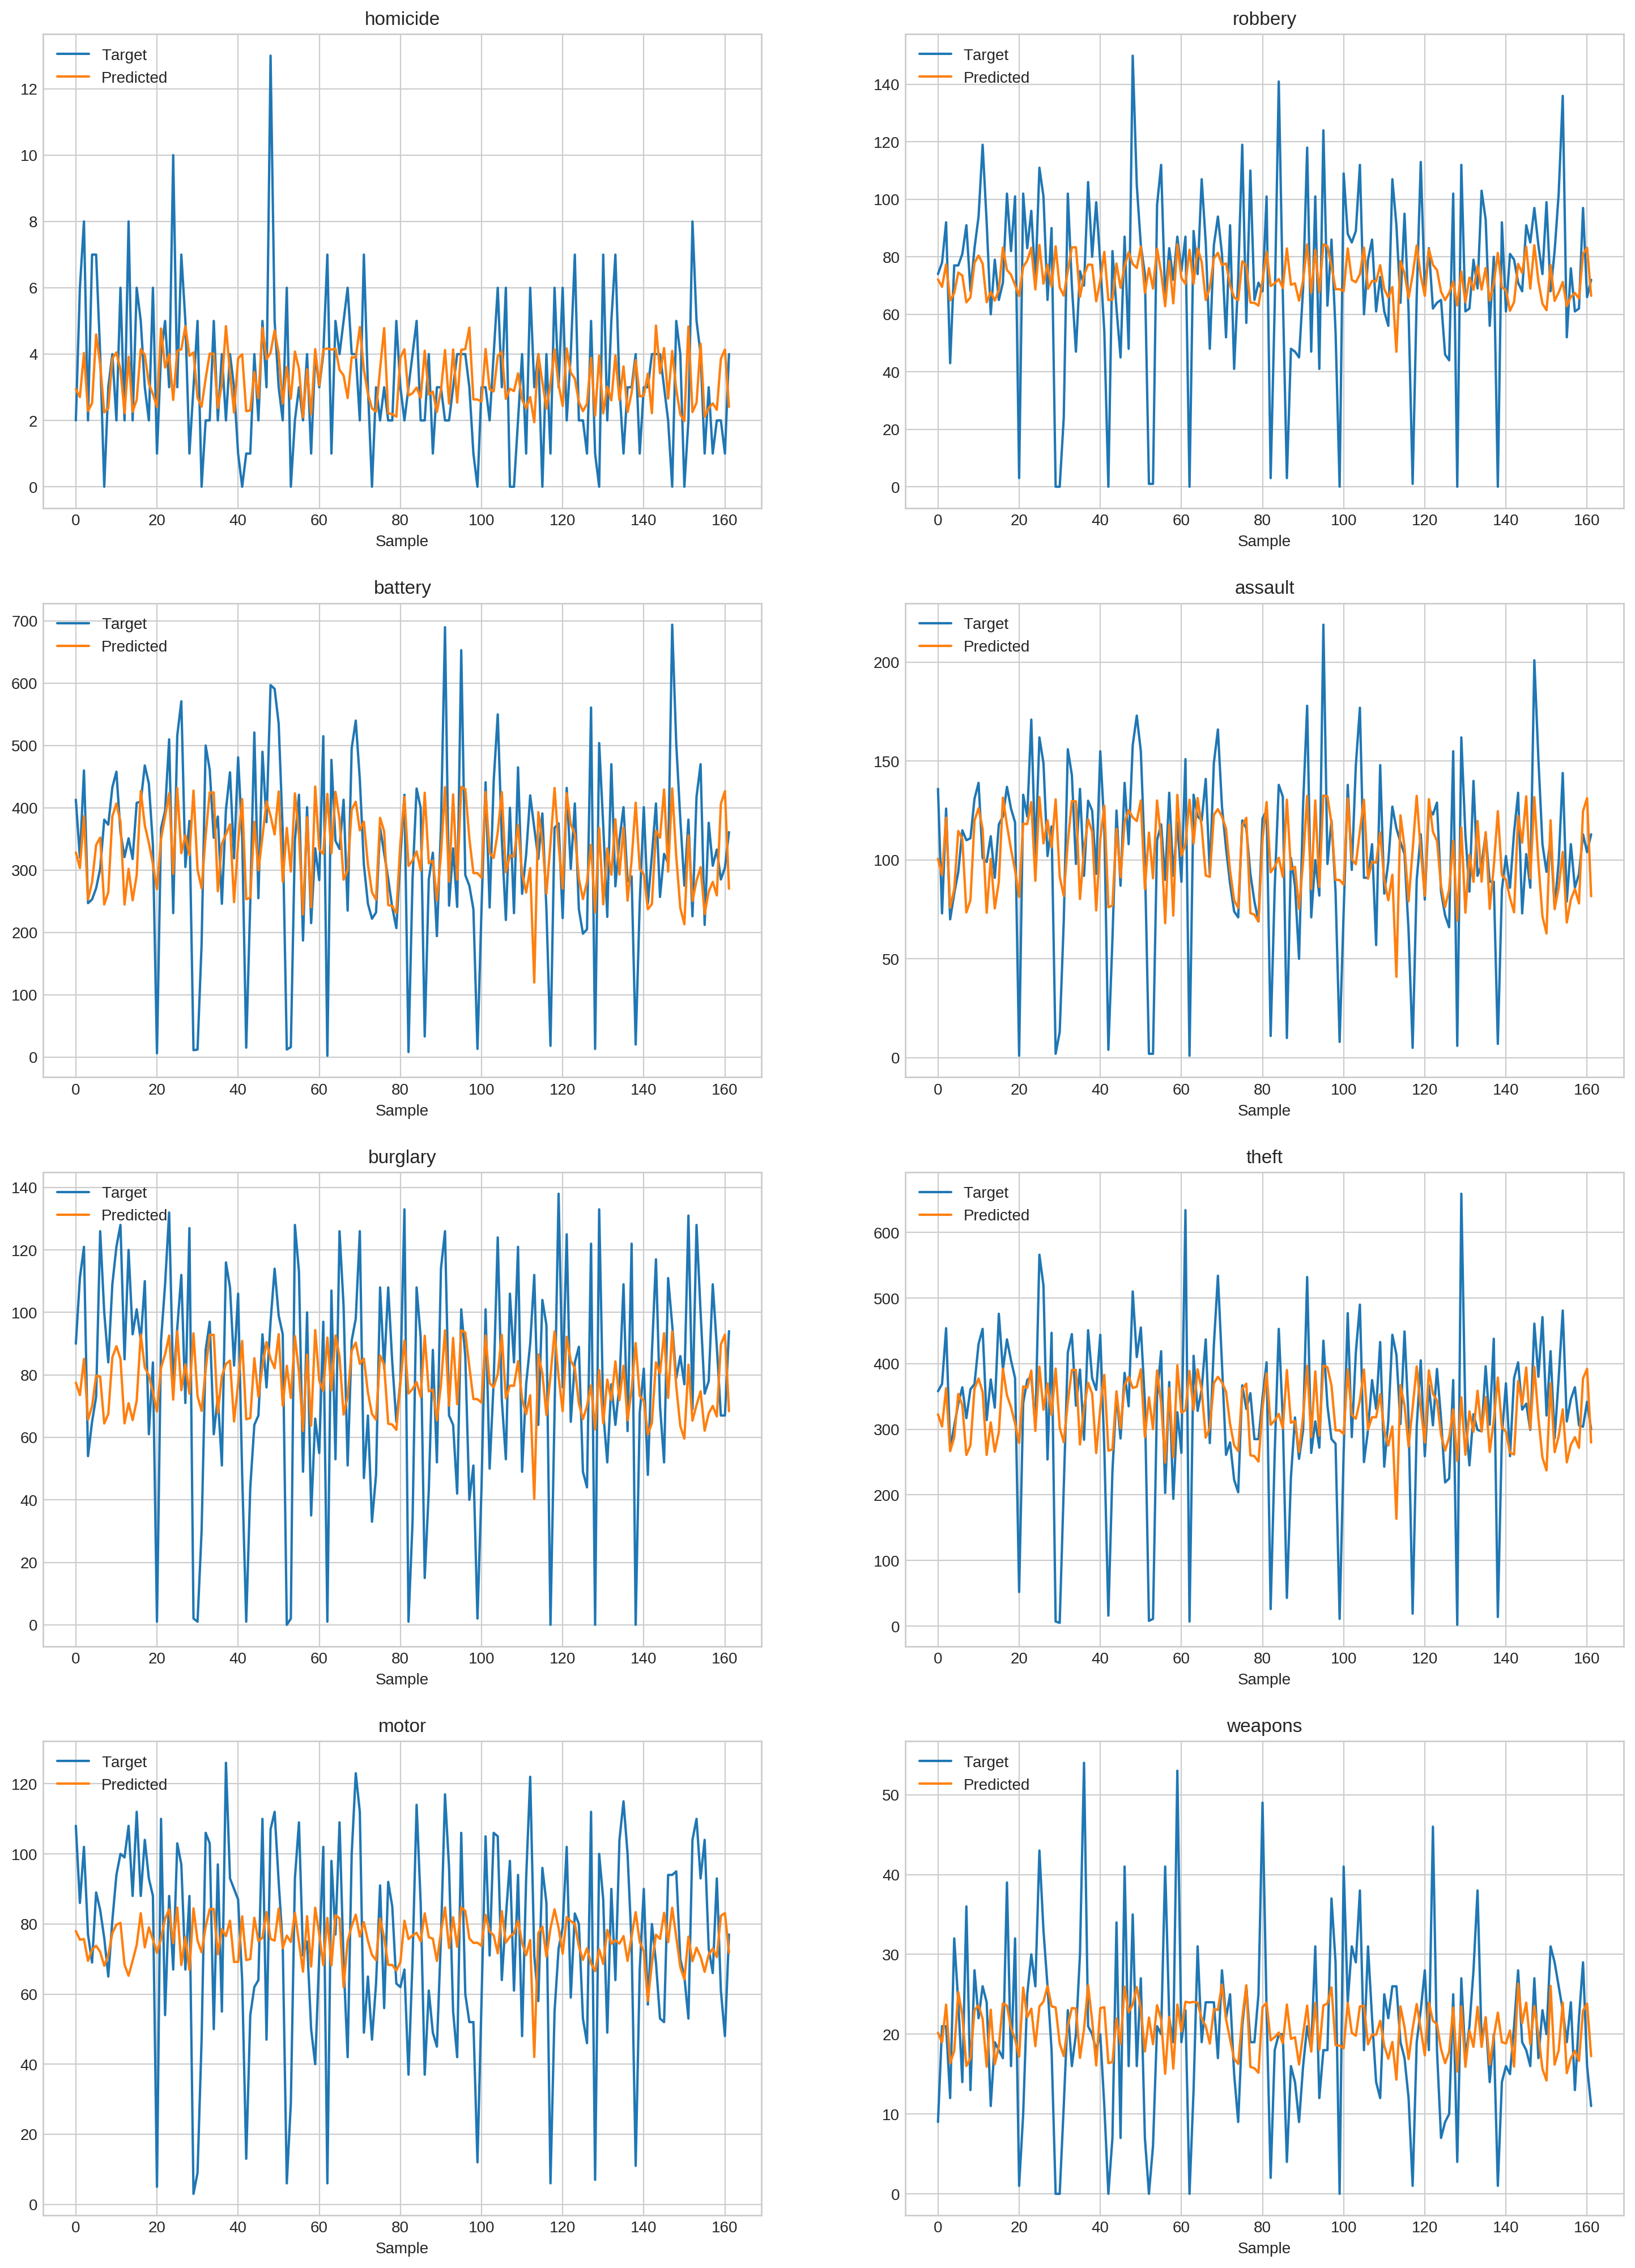

In [55]:
# #############################################################################
# Use the best network
    
itr = 300
train_f = 0.80

network = best[0]
print('Network:', network)
Y, _T, error = get_values(X, T, network, train_f, itr, partition = True)

# #############################################################################
# Results V1.  Showing first 200 samples 

def data_plot(Y, T, error, itr, bound):
    print('ERROR MIN:', np.min(error), 'for', itr, 'iterations')
    print('RMSE:', np.mean((Y - T)**2))
    col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']
    
    plt.figure(figsize=(18,25))
    for i in range(T.shape[1]):
        plt.subplot(4,2,i+1)  
        plt.plot(T[:bound,i]), plt.plot(Y[:bound,i])
        plt.title(col[i])
        plt.xlabel('Sample'), plt.ylabel('')
        plt.legend(['Target', 'Predicted'], loc='upper left')
    
    plt.show() 
    
bound = 200
data_plot(Y, _T, error, itr, bound)

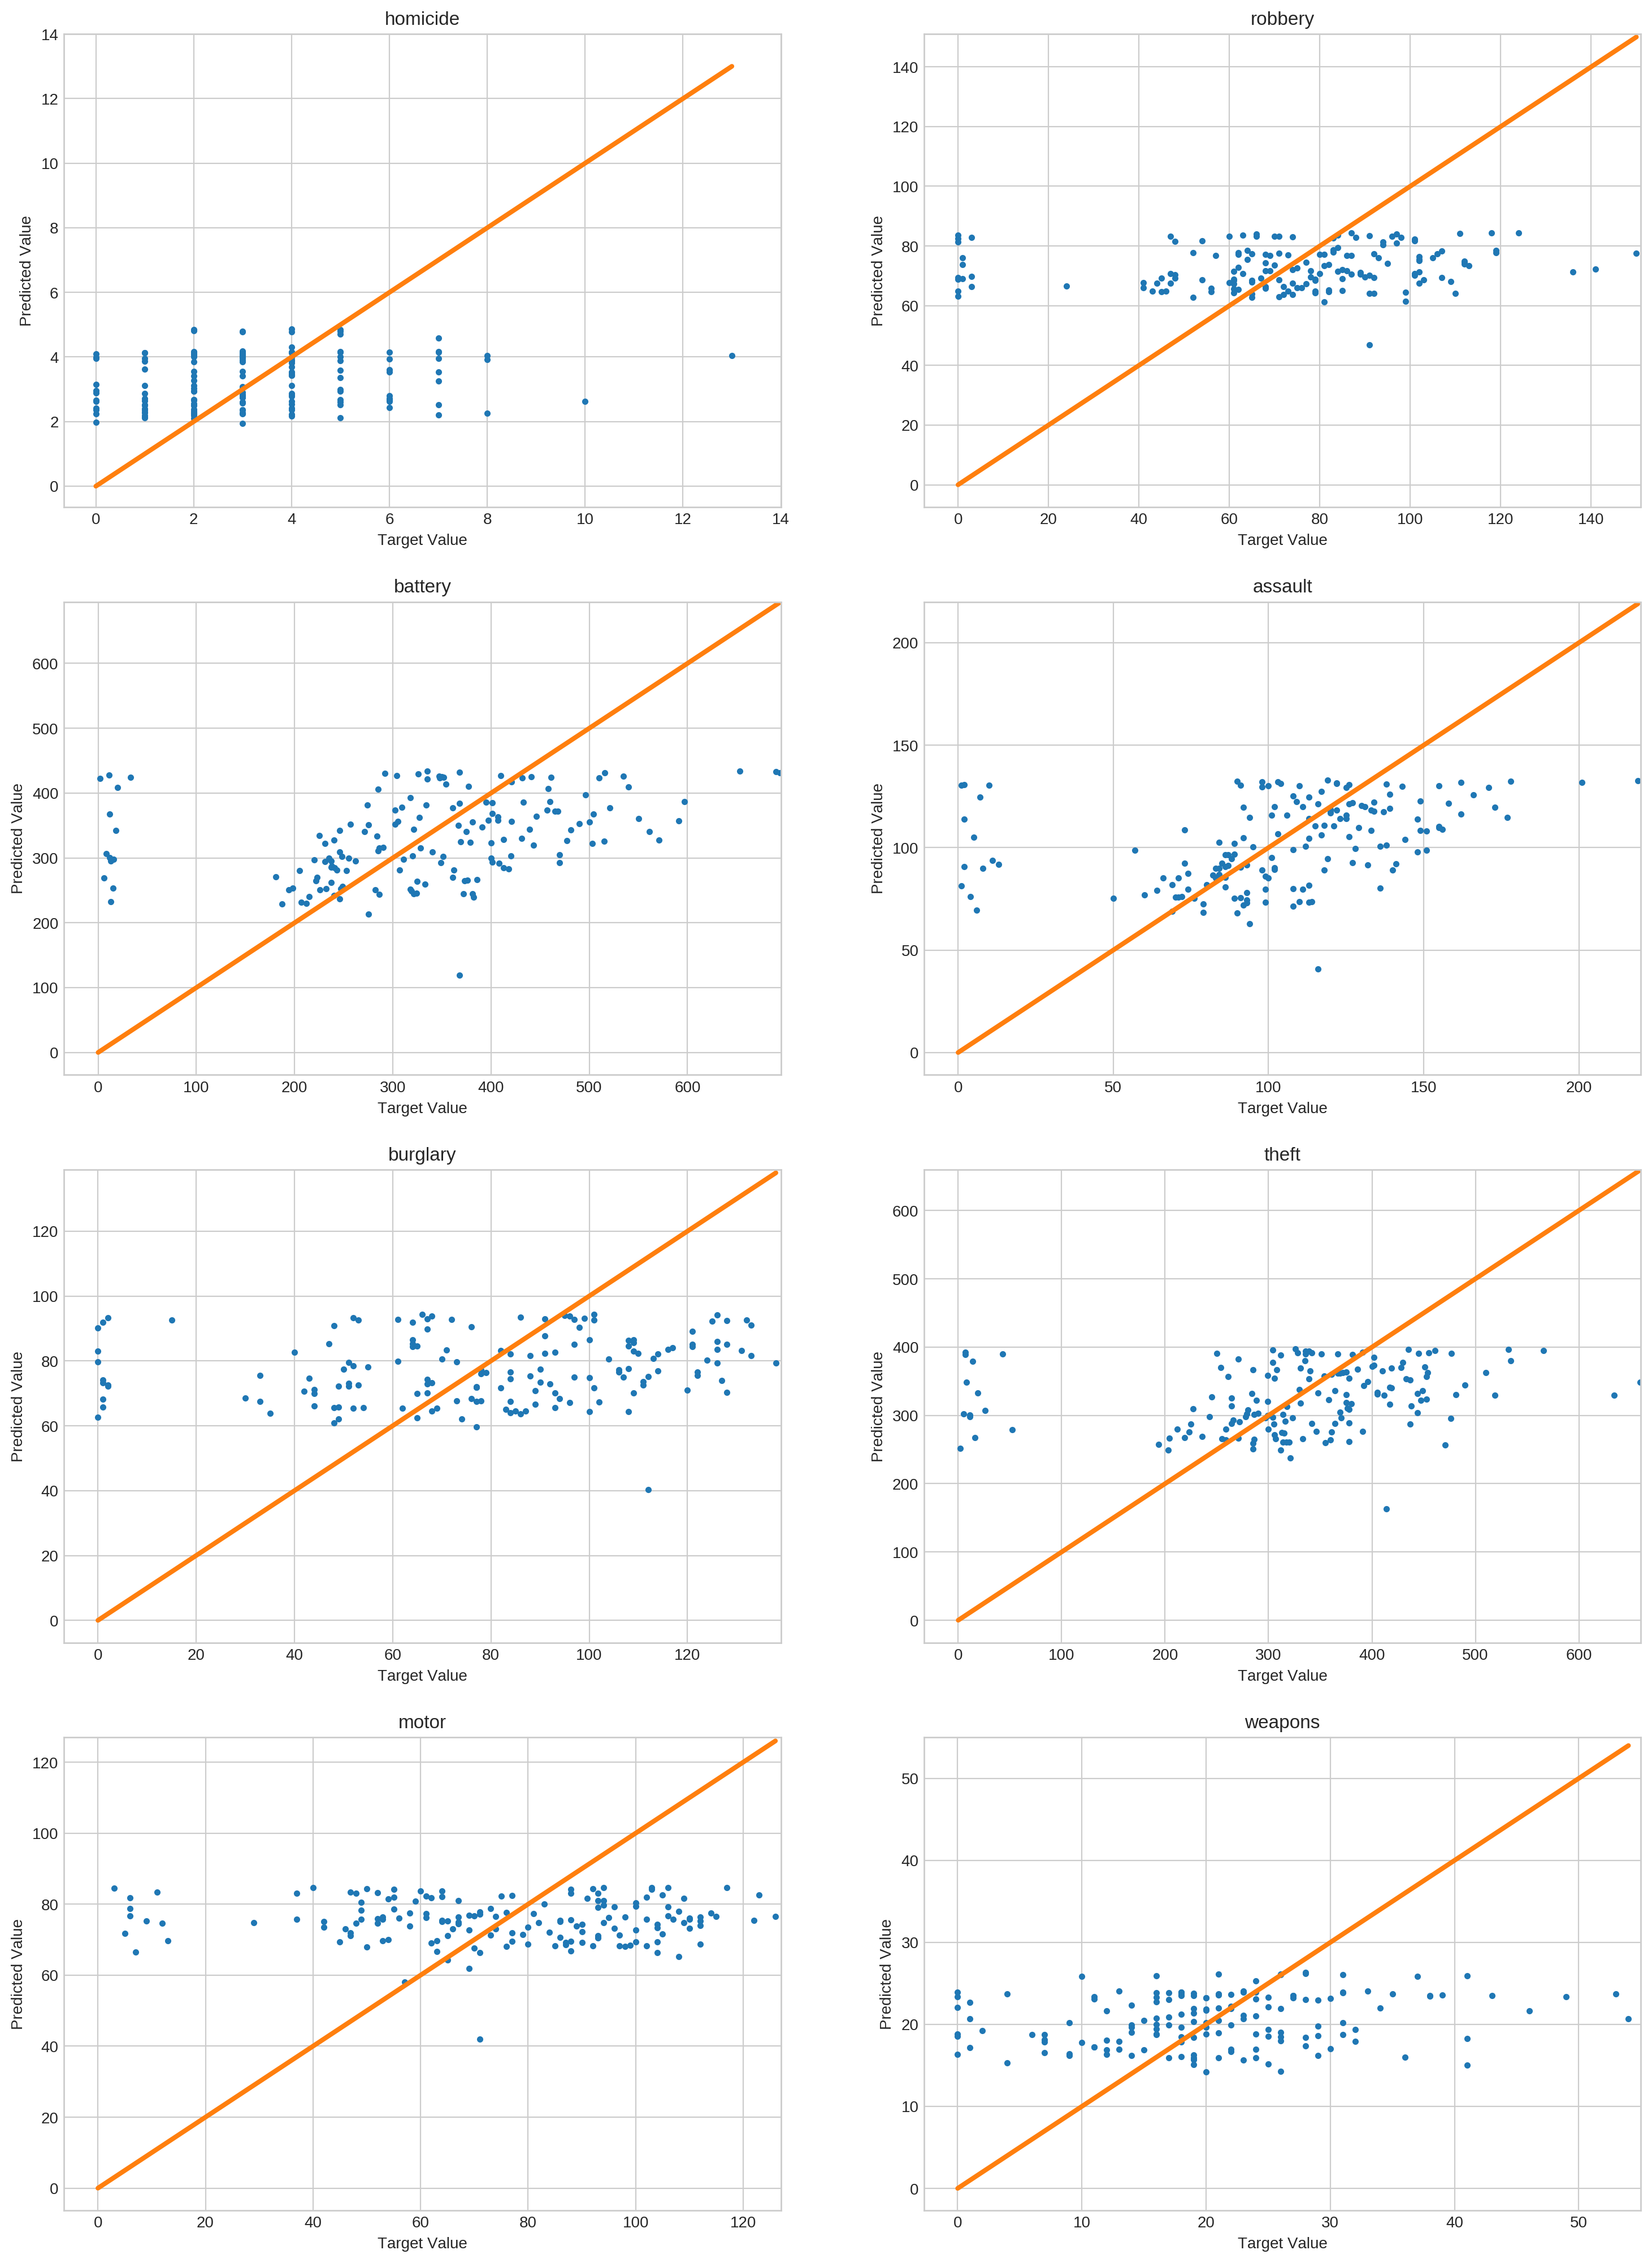

In [56]:
# #############################################################################
# Results V2

col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

plt.figure(figsize=(18,25))

for i in range(T.shape[1]):
    m = np.max(_T[:,i]) + 1
    plt.subplot(4,2,i+1)  
    plt.plot(_T[:,i], Y[:,i], '.'), plt.plot(range(m), lw='3')
    axes = plt.gca()
    axes.set_xlim([None,m]), axes.set_ylim([None,m])
    plt.title(col[i])
    plt.xlabel('Target Value'), plt.ylabel('Predicted Value')
    
plt.show()

### Scikit-Learn

Estimators developed for regression:

- LinearRegression
- Ridge
- Lasso
- SVR (SBR, Linear, Ploynomial)

/usr/local/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Linear Regression
train score: 0.16775426021234463
test score: 0.015799204162823877 

Ridge Regression, low alpha
train score: 0.1676017660153648
test score: 0.01819905172081393 

Ridge Regression, high alpha
train score: 0.09617069139863343
test score: 0.06235167327858648 



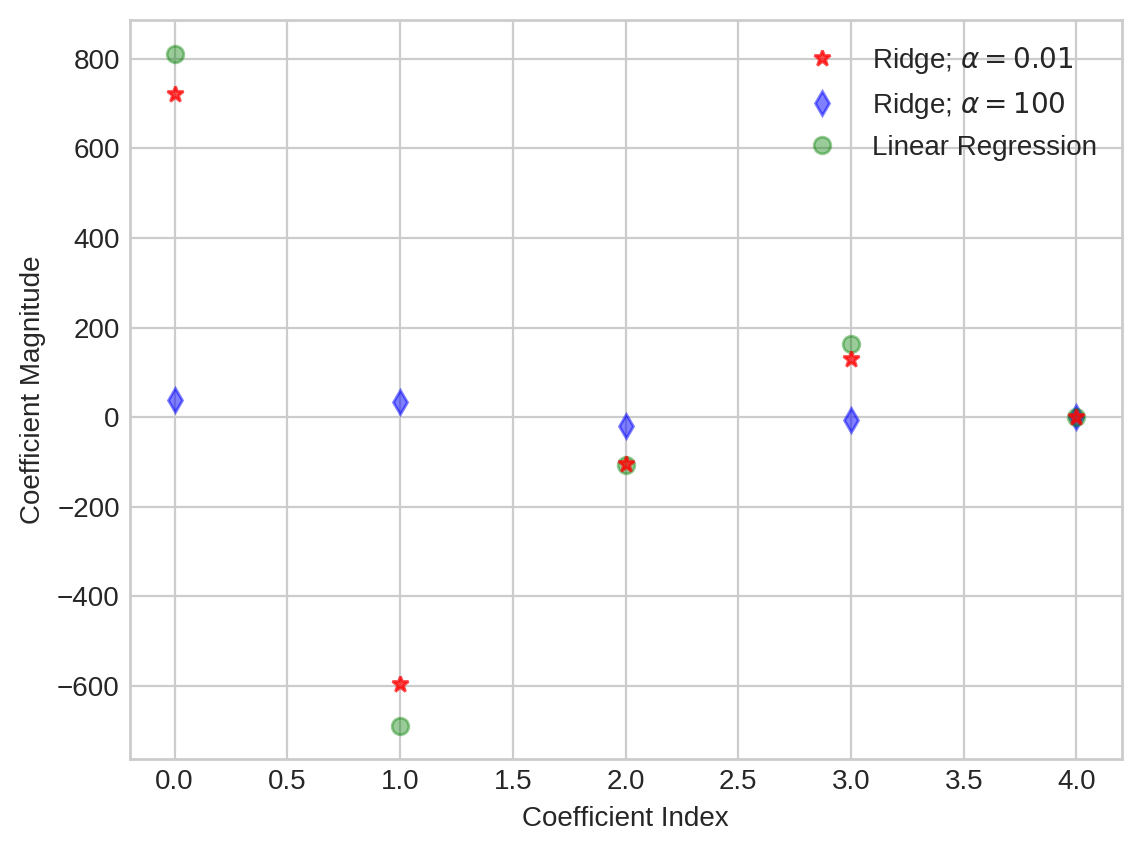

In [21]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# #############################################################################
# Read the data
data = pd.read_csv('../CrimeWeatherOutputByWeek/5.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

cols = ['homicide', 'robbery', 'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

T = data['theft']
X = data.drop(['date'] + cols, axis=1)

X_train,X_test,T_train,T_test = train_test_split(X, T, test_size=0.3, random_state=3)

# #############################################################################
# Fit regression model
lr = LinearRegression()
lr.fit(X_train, T_train)

train_score = lr.score(X_train, T_train)
test_score = lr.score(X_test, T_test)

print('Linear Regression')
print("train score:", train_score)
print("test score:", test_score, '\n')

rr = Ridge(alpha=0.01)
rr.fit(X_train, T_train)

Ridge_train_score = rr.score(X_train, T_train)
Ridge_test_score = rr.score(X_test, T_test)

print('Ridge Regression, low alpha')
print("train score:", Ridge_train_score)
print("test score:", Ridge_test_score, '\n')

rr100 = Ridge(alpha=100)
rr100.fit(X_train, T_train)

Ridge_train_score100 = rr100.score(X_train, T_train)
Ridge_test_score100 = rr100.score(X_test, T_test)

print('Ridge Regression, high alpha')
print("train score:", Ridge_train_score100)
print("test score:", Ridge_test_score100, '\n')

# #############################################################################
# Results
plt.plot(rr.coef_, alpha=0.7, linestyle='none', marker='*',
         color='red', label=r'Ridge; $\alpha = 0.01$', zorder=7)
plt.plot(rr100.coef_, alpha=0.5, linestyle='none', marker='d',
         color='blue', label=r'Ridge; $\alpha = 100$')
plt.plot(lr.coef_, alpha=0.4, linestyle='none', marker='o',
         color='green', label='Linear Regression')

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')

plt.legend(loc=1)
plt.show()

alpha = 0.1
training score: 0.16039126938205917
test score:  0.0330514545147369
number of features used:  4 

alpha = 0.01
training score: 0.16760006016204132
test score:  0.01805899549592671
number of features used: 4 

alpha = 0.0001
training score: 0.16775424478418344
test score:  0.01582240458936779
number of features used: 4 



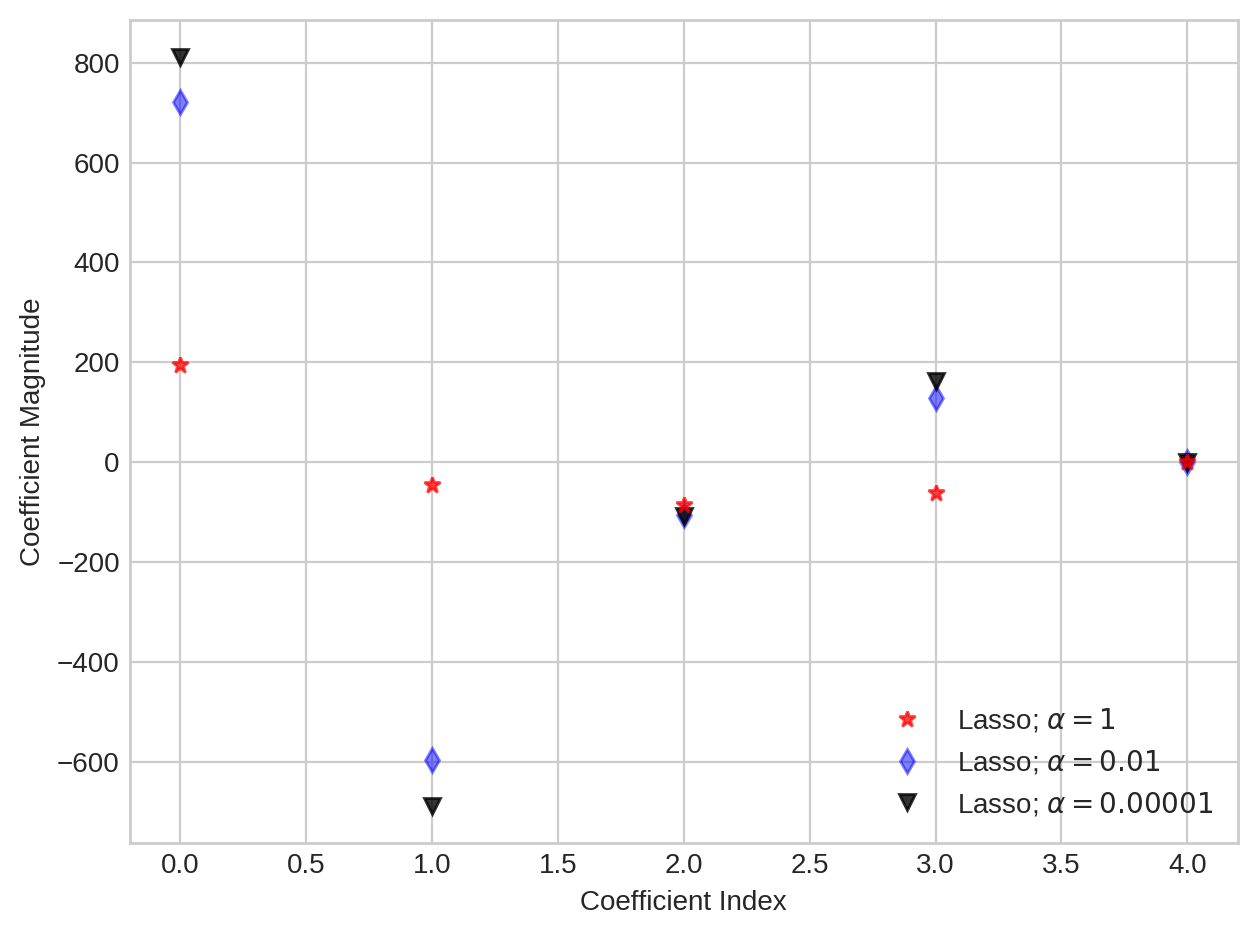

In [22]:
# Difference of lasso and ridge regression is that some of the coefficients can be zero i.e. some of the features are 
# completely neglected
from sklearn.linear_model import Lasso

# #############################################################################
# Read the Data
data = pd.read_csv('../CrimeWeatherOutputByWeek/5.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

cols = ['homicide', 'robbery', 'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

T = data['theft']
X = data.drop(['date'] + cols, axis=1)

X_train,X_test,T_train,T_test = train_test_split(X, T, test_size=0.3, random_state=3)

# #############################################################################
# Fit regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, T_train)
train_score = lasso.score(X_train, T_train)
test_score = lasso.score(X_test, T_test)
coeff_used = np.sum(lasso.coef_!=0)

print('alpha = 0.1')
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used, '\n')

lasso001 = Lasso(alpha=0.01, max_iter=10e6)
lasso001.fit(X_train, T_train)
train_score001 = lasso001.score(X_train, T_train)
test_score001 = lasso001.score(X_test, T_test)
coeff_used001 = np.sum(lasso001.coef_!=0)

print('alpha = 0.01')
print("training score:", train_score001)
print("test score: ", test_score001)
print("number of features used:", coeff_used001, '\n')

lasso00001 = Lasso(alpha=0.0001, max_iter=10e6)
lasso00001.fit(X_train, T_train)
train_score00001 = lasso00001.score(X_train, T_train)
test_score00001 = lasso00001.score(X_test, T_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)

print('alpha = 0.0001')
print("training score:", train_score00001)
print("test score: ", test_score00001)
print("number of features used:", coeff_used00001, '\n')

# #############################################################################
# Results
plt.plot(lasso.coef_, alpha=0.7, linestyle='none', marker='*',
         color='red', label=r'Lasso; $\alpha = 1$', zorder=7)
plt.plot(lasso001.coef_, alpha=0.5, linestyle='none', marker='d',
         color='blue', label=r'Lasso; $\alpha = 0.01$')
plt.plot(lasso00001.coef_, alpha=0.8, linestyle='none', marker='v',
         color='black', label=r'Lasso; $\alpha = 0.00001$')

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc=4)

plt.tight_layout()
plt.show()

Kernel RBF
training score: 0.09625034571217395
Kernel Linear
training score: 0.09740477324619702
Kernel Ploy
training score: 0.09384348613111315


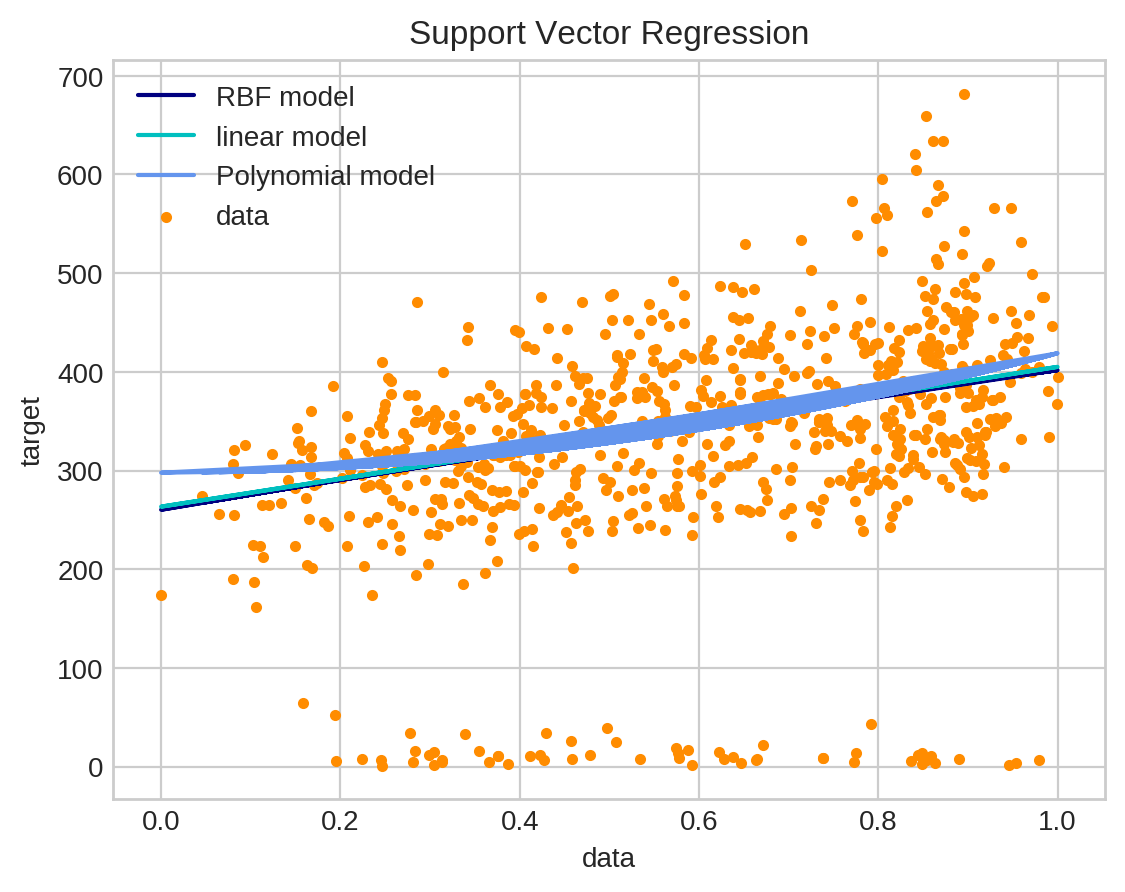

In [23]:
from sklearn.svm import SVR

# #############################################################################
# Read the Data
data = pd.read_csv('../CrimeWeatherOutputByWeek/5.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

cols = ['homicide', 'robbery', 'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

T = np.array(data['theft'])
X = np.array([[x] for x in data['dry']])

# X_train,X_test,T_train,T_test = train_test_split(X, T, test_size=0.3, random_state=3)

# #############################################################################
# Fit regression model

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
y_rbf = svr_rbf.fit(X, T)
print('Kernel RBF')
print("training score:", y_rbf.score(X, T))
y_rbf = y_rbf.predict(X)

svr_lin = SVR(kernel='linear', C=1e3)
y_lin = svr_lin.fit(X, T)
print('Kernel Linear')
print("training score:", y_lin.score(X, T))
y_lin = y_lin.predict(X)

svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_poly = svr_poly.fit(X, T)
print('Kernel Ploy')
print("training score:", y_poly.score(X, T))
y_poly = y_poly.predict(X)

# #############################################################################
# Results

lw = 1.5
plt.scatter(X, T, marker='.', color='darkorange', label='data')

plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X, y_lin, color='c', lw=lw, label='linear model')
plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')

plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()